<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Data Wrangling</h1><h2>Assignment 2 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

# Table of Contents

1. [Load and Explore the Data](#1)
2. [Data Wrangling on multiple tables](#2)
3. [Data Cleansing and Transformation](#3)
4. [Machine Learning Modelling](#4)
5. [Report](#5)

In [1]:
# import the packages
import glob
import os
from pathlib import Path
import math;
import time;
import random;
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import matplotlib.gridspec as GridSpec;
import seaborn as sns;
import scipy.stats as stats;

from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LinearRegression;
from sklearn.compose import ColumnTransformer;
from sklearn.pipeline import Pipeline;

import feature_engine.imputation as mdi;
from feature_engine.imputation import MeanMedianImputer;
from feature_engine.imputation import CategoricalImputer;
from feature_engine.imputation import EndTailImputer;
from feature_engine.imputation import ArbitraryNumberImputer;
from feature_engine.imputation import RandomSampleImputer;
from feature_engine.imputation import AddMissingIndicator;

from feature_engine.outliers import Winsorizer

from feature_engine.encoding import OneHotEncoder;
from feature_engine.encoding import OrdinalEncoder;
from feature_engine.encoding import CountFrequencyEncoder;
from feature_engine.encoding import MeanEncoder;
from feature_engine.encoding import RareLabelEncoder;

from feature_engine.transformation import LogTransformer;
from feature_engine.transformation import ReciprocalTransformer;
from feature_engine.transformation import PowerTransformer;
from feature_engine.transformation import BoxCoxTransformer;
from feature_engine.transformation import YeoJohnsonTransformer;

from feature_engine.discretisation import EqualWidthDiscretiser;
from feature_engine.discretisation import EqualFrequencyDiscretiser;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import RobustScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.preprocessing import MaxAbsScaler;

from sklearn.preprocessing import OrdinalEncoder as sk_oe;
from sklearn.preprocessing import PolynomialFeatures;
from sklearn.decomposition import PCA;

Problem Formulation: Create a model that is able to predict whether a driver will finish in the top 3 positions (podium finish) in a future race?

<a id= "1"></a>
# Step 1: Load and Explore the Data
[Go to Start](#Start)

In [57]:
# loading the different csv files
folder_path = './datasets/f1db_csv_mod'

csv_files = glob.glob(folder_path + '/*.csv')

f1 = {}

for file in csv_files:
    file_name = os.path.basename(file)
    f1_name = os.path.splitext(file_name)[0]
    f1[f1_name] = pd.read_csv(file)


In [58]:
# loading the different meta data
folder_path = './DataDict'
DataDict_files = glob.glob(folder_path + '/*.txt')

DataDict = {}

for file in DataDict_files:
    file_name = os.path.basename(file)
    DataDict_name = os.path.splitext(file_name)[0]
    
    with open(file, 'r') as f:
        DataDict[DataDict_name] = f.read()

In [59]:
import ipywidgets as widgets

dropdown = widgets.Dropdown(
    options=list(f1.keys()),  # Use keys of f1 dict as options
    description='DataFrames:'
)

output = widgets.Output()

def on_dropdown_change(change):
    selected_df = f1[change.new]
    DataDict_filename = change.new
    with output:
        output.clear_output()
        print()
        print("DataFrame:", change.new)
        print()
#         print(selected_df.head())
        display(selected_df.head())
        print("-----------")
        print()
        print(selected_df.info())
        print("-----------")
        print()
        missing_values = selected_df.isnull().sum()
        print(f"Missing values in {DataDict_filename}")
        print()
        print(missing_values)
        print("-----------")
        print()
        print(f"Shape of {DataDict_filename}")
        print(selected_df.shape)
        
        if DataDict_filename in DataDict:
            print()
            print("Data Dictionary:")
            print()
            print(DataDict[DataDict_filename])
        else:
            print("Data Dictionary not found for", change.new)
    

dropdown.observe(on_dropdown_change, names='value')

widgets.VBox([dropdown, output])

<a id= "2"></a>
# Step 2: Data Wrangling on multiple tables 
[Go to Start](#Start)

In [5]:
# Load the data from CSV files
path = './datasets/f1db_csv_mod/'
results = pd.read_csv(path + 'results_mod.csv', na_values=r'\N')
driver_standings = pd.read_csv(path + 'driver_standings_mod.csv', na_values=r'\N')
races = pd.read_csv(path + 'races_mod.csv', na_values=r'\N')
circuits = pd.read_csv(path + 'circuits_mod.csv', na_values=r'\N')
drivers = pd.read_csv(path + 'drivers_mod.csv', na_values=r'\N')


In [6]:
merged_data = results.merge(driver_standings, on=['raceId', 'driverId'], how='left')
merged_data = merged_data.merge(races, on='raceId', how='left')
merged_data = merged_data.merge(circuits, on='circuitId', how='left')
merged_data = merged_data.merge(drivers, on='driverId', how='left')
merged_data.columns


Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position_x', 'positionText_x', 'positionOrder', 'points_x', 'laps',
       'time_x', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverStandingsId', 'points_y',
       'position_y', 'positionText_y', 'wins', 'round', 'circuitId', 'name_x',
       'date', 'time_y', 'url_x', 'circuitRef', 'name_y', 'location',
       'country', 'lat', 'lng', 'alt', 'url_y', 'driverRef', 'number_y',
       'code', 'forename', 'surname', 'dob', 'nationality', 'url'],
      dtype='object')

In [7]:
columns_to_drop = [
    'resultId', 'constructorId', 'number_x', 'time_x', 'milliseconds', 'fastestLapSpeed', 'statusId',
    'driverStandingsId', 'round', 'circuitId', 'name_x', 'time_y', 'url_x', 'circuitRef','name_y',
    'location', 'lat', 'lng', 'alt', 'url_y', 'driverRef', 'number_y', 'code', 'forename', 'surname', 
    'url', 'positionText_x','positionText_y','position_y','positionOrder','rank','points_x','points_y',
]

# Drop the specified columns from the DataFrame
merged_data.drop(columns=columns_to_drop, inplace=True)

# Display the modified DataFrame
merged_data.head()


,raceId,driverId,grid,position_x,laps,fastestLap,fastestLapTime,wins,date,country,dob,nationality
0,18,1,1,1.0,58,39.0,01:27.5,1.0,3/16/2008,Australia,1985-01-07,British
1,18,2,5,2.0,58,41.0,01:27.7,0.0,3/16/2008,Australia,1977-05-10,German
2,18,3,7,3.0,58,41.0,01:28.1,0.0,3/16/2008,Australia,1985-06-27,German
3,18,4,11,4.0,58,58.0,01:28.6,0.0,3/16/2008,Australia,1981-07-29,Spanish
4,18,5,3,5.0,58,43.0,01:27.4,0.0,3/16/2008,Australia,1981-10-19,Finnish


In [8]:
merged_data['position_x'].fillna(-1, inplace=True)
merged_data['podium_finish'] = ((merged_data['position_x'] >= 1) & (merged_data['position_x'] <= 3)).astype(int)
merged_data.drop('position_x', axis=1, inplace=True)
merged_data.head()

,raceId,driverId,grid,laps,fastestLap,fastestLapTime,wins,date,country,dob,nationality,podium_finish
0,18,1,1,58,39.0,01:27.5,1.0,3/16/2008,Australia,1985-01-07,British,1
1,18,2,5,58,41.0,01:27.7,0.0,3/16/2008,Australia,1977-05-10,German,1
2,18,3,7,58,41.0,01:28.1,0.0,3/16/2008,Australia,1985-06-27,German,1
3,18,4,11,58,58.0,01:28.6,0.0,3/16/2008,Australia,1981-07-29,Spanish,0
4,18,5,3,58,43.0,01:27.4,0.0,3/16/2008,Australia,1981-10-19,Finnish,0


In [9]:
# Looking at the values for each column
for column in merged_data:
    print (f"{column:-^30} ({merged_data[column].nunique()})");
    print (merged_data[column].value_counts());
    print ("\n");

------------raceId------------ (1057)
800    55
809    47
361    39
357    39
370    39
       ..
657    14
668    14
827    13
660    13
765    10
Name: raceId, Length: 1057, dtype: int64


-----------driverId----------- (853)
8      352
4      336
22     326
18     309
30     308
      ... 
604      1
605      1
614      1
616      1
228      1
Name: driverId, Length: 853, dtype: int64


-------------grid------------- (35)
0     1598
1     1068
7     1067
4     1064
11    1064
9     1064
5     1064
10    1063
3     1062
8     1062
12    1059
2     1058
13    1058
6     1057
14    1052
15    1045
16    1032
17    1021
18     984
19     970
20     934
21     697
22     656
23     453
24     429
25     301
26     248
27      46
28      30
29      25
30      19
31      18
32      17
33      13
34       1
Name: grid, dtype: int64


-------------laps------------- (172)
0      2495
53      875
70      873
52      752
56      720
       ... 
192       1
181       1
119       1
120       1
12

<a id= "3"></a>
# Step 3: Data Cleansing and Transformation
[Go to Start](#Start)

In [10]:
# Check for duplicates
num_duplicates = merged_data.duplicated().sum()
num_duplicates

3

In [11]:
merged_data.drop_duplicates()

,raceId,driverId,grid,laps,fastestLap,fastestLapTime,wins,date,country,dob,nationality,podium_finish
0,18,1,1,58,39.0,01:27.5,1.0,3/16/2008,Australia,1985-01-07,British,1
1,18,2,5,58,41.0,01:27.7,0.0,3/16/2008,Australia,1977-05-10,German,1
2,18,3,7,58,41.0,01:28.1,0.0,3/16/2008,Australia,1985-06-27,German,1
3,18,4,11,58,58.0,01:28.6,0.0,3/16/2008,Australia,1981-07-29,Spanish,0
4,18,5,3,58,43.0,01:27.4,0.0,3/16/2008,Australia,1981-10-19,Finnish,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25394,1073,815,4,55,51.0,01:26.4,1.0,12/12/2021,UAE,1990-01-26,Mexican,0
25395,1073,849,16,50,30.0,01:29.3,0.0,12/12/2021,UAE,1995-06-29,Canadian,0
25396,1073,841,14,33,33.0,01:29.4,0.0,12/12/2021,UAE,1993-12-14,Italian,0
25397,1073,847,17,26,23.0,01:30.6,0.0,12/12/2021,UAE,1998-02-15,British,0


In [12]:
# Check for null values
merged_data.isnull().sum()

raceId                0
driverId              0
grid                  0
laps                  0
fastestLap        18446
fastestLapTime    18446
wins                481
date                206
country               0
dob                   0
nationality           0
podium_finish         0
dtype: int64

## Step 3.1: Data Cleaning

### Missing Value Imputation
wins:<br>
> Replacing values with an arbitrary number<br>
Explanation:
>> This column seem to be related to driver standings and performance metrics. It is reasonable to assume that a missing value might indicate that the driver did not win. Therefore, I replaced the missing values with 0 as it distinguishes missing values from actual winnings.

fastestLap, fastestLapTime:<br>
> Replacing values with an arbitrary number<br>
Explanation:
>> Since these column represents the fastest lap and fastest lap time of the driver in a race, it is reasonable to assume that a missing value might indicate that the driver did not set a fastest lap or the information is missing, I can use an arbitrary value like -1 to differentiate between drivers who did not set a fastest lap and fastest lap time. 

date:<br>
> Replacing values with respect to the raceID<br>
Explanation:
>> The date column represents the date of the race. Since the dates is sorted according to the raceID, I can impute missing dates based on raceID.


In [13]:
# Replacing missing values in the date column with
import datetime
from datetime import timedelta
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')

# Iterate over the DataFrame and replace 'NA' values with dynamic date ranges
for index, row in merged_data.sort_values(by=['raceId', 'date']).iterrows():
    if pd.isna(row['date']):
        prev_date = None
        next_date = None
        
        # Find the previous non-null date
        for i in range(index - 1, -1, -1):
            if not pd.isna(merged_data.at[i, 'date']):
                prev_date = merged_data.at[i, 'date']
                break
        
        # Find the next non-null date
        for i in range(index + 1, len(merged_data)):
            if not pd.isna(merged_data.at[i, 'date']):
                next_date = merged_data.at[i, 'date']
                break
        
        date_range = (next_date - prev_date).days
        if date_range > 0:
            random_days = random.randint(0, date_range)
            random_date = prev_date + timedelta(days=random_days)
            merged_data.at[index, 'date'] = random_date
        else:
            merged_data.at[index, 'date'] = prev_date

In [14]:
# Extracting year from 'dob' column
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')
merged_data['year'] = merged_data['date'].dt.year
merged_data.drop('date', axis=1, inplace=True)
merged_data.head()

,raceId,driverId,grid,laps,fastestLap,fastestLapTime,wins,country,dob,nationality,podium_finish,year
0,18,1,1,58,39.0,01:27.5,1.0,Australia,1985-01-07,British,1,2008
1,18,2,5,58,41.0,01:27.7,0.0,Australia,1977-05-10,German,1,2008
2,18,3,7,58,41.0,01:28.1,0.0,Australia,1985-06-27,German,1,2008
3,18,4,11,58,58.0,01:28.6,0.0,Australia,1981-07-29,Spanish,0,2008
4,18,5,3,58,43.0,01:27.4,0.0,Australia,1981-10-19,Finnish,0,2008


In [15]:
# Replacing missing values with an arbitrary constant
for var in ['fastestLap','fastestLapTime',]:    
    merged_data[var].fillna(-1, inplace=True)

In [16]:
# Extraacting milliseconds from 'fastestLapTime' column
merged_data['fastestLapTime'] = pd.to_datetime(merged_data['fastestLapTime'], errors='coerce')
merged_data['fastestLapTime_ms'] = merged_data['fastestLapTime'].dt.hour*60*1000 + merged_data['fastestLapTime'].dt.minute*1000 + merged_data['fastestLapTime'].dt.second
merged_data.drop('fastestLapTime', axis=1, inplace=True)
merged_data=merged_data.dropna(axis=0) # noticed 1 row with missing value, so I decided to drop it as it is too insignificant
merged_data.head()

,raceId,driverId,grid,laps,fastestLap,wins,country,dob,nationality,podium_finish,year,fastestLapTime_ms
0,18,1,1,58,39.0,1.0,Australia,1985-01-07,British,1,2008,87030.0
1,18,2,5,58,41.0,0.0,Australia,1977-05-10,German,1,2008,87042.0
2,18,3,7,58,41.0,0.0,Australia,1985-06-27,German,1,2008,88006.0
3,18,4,11,58,58.0,0.0,Australia,1981-07-29,Spanish,0,2008,88036.0
4,18,5,3,58,43.0,0.0,Australia,1981-10-19,Finnish,0,2008,87024.0


After careful considerations, I realised that fastestLap and fastestLapTime_ms are variables that I will not know before the race, therefore i decided to come up with a variable personalBest and drop the 2 columns.

In [17]:
personal_best = merged_data.groupby('driverId')['fastestLapTime_ms'].min()
merged_data["personalBest"] = merged_data["driverId"].map(personal_best)
merged_data.drop(['fastestLap','fastestLapTime_ms'], axis=1, inplace=True)
merged_data.head()


,raceId,driverId,grid,laps,wins,country,dob,nationality,podium_finish,year,personalBest
0,18,1,1,58,1.0,Australia,1985-01-07,British,1,2008,66042.0
1,18,2,5,58,0.0,Australia,1977-05-10,German,1,2008,73006.0
2,18,3,7,58,0.0,Australia,1985-06-27,German,1,2008,68030.0
3,18,4,11,58,0.0,Australia,1981-07-29,Spanish,0,2008,68024.0
4,18,5,3,58,0.0,Australia,1981-10-19,Finnish,0,2008,74000.0


In [18]:
# Replacing missing values with an arbitrary constant
merged_data['wins'].fillna(0, inplace=True)
merged_data.head()

,raceId,driverId,grid,laps,wins,country,dob,nationality,podium_finish,year,personalBest
0,18,1,1,58,1.0,Australia,1985-01-07,British,1,2008,66042.0
1,18,2,5,58,0.0,Australia,1977-05-10,German,1,2008,73006.0
2,18,3,7,58,0.0,Australia,1985-06-27,German,1,2008,68030.0
3,18,4,11,58,0.0,Australia,1981-07-29,Spanish,0,2008,68024.0
4,18,5,3,58,0.0,Australia,1981-10-19,Finnish,0,2008,74000.0


In [19]:
# Extracting year from 'dob' column
merged_data['dob'] = pd.to_datetime(merged_data['dob'], errors='coerce')
merged_data['dob_year'] = merged_data['dob'].dt.year
merged_data.drop('dob', axis=1, inplace=True)
merged_data.head()

,raceId,driverId,grid,laps,wins,country,nationality,podium_finish,year,personalBest,dob_year
0,18,1,1,58,1.0,Australia,British,1,2008,66042.0,1985
1,18,2,5,58,0.0,Australia,German,1,2008,73006.0,1977
2,18,3,7,58,0.0,Australia,German,1,2008,68030.0,1985
3,18,4,11,58,0.0,Australia,Spanish,0,2008,68024.0,1981
4,18,5,3,58,0.0,Australia,Finnish,0,2008,74000.0,1981


### Dealing with Outliers


In [20]:
num_cols = [n for n in merged_data.columns if merged_data[n].dtypes !='O']
Q1 = merged_data[num_cols].quantile(0.25)
Q3 = merged_data[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Define a function to identify outliers in each column
def identify_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = merged_data[(merged_data[column] < lower_bound) | (merged_data[column] > upper_bound)]
    return outliers

# Iterate through each column and identify outliers
outliers_per_column = {}
for column in num_cols:
    outliers = identify_outliers(column)
    outliers_per_column[column] = outliers

# Print the outliers for each column
for column, outliers in outliers_per_column.items():
    print(f"Outliers in {column}:\n{outliers}\n")




Outliers in raceId:
Empty DataFrame
Columns: [raceId, driverId, grid, laps, wins, country, nationality, podium_finish, year, personalBest, dob_year]
Index: []

Outliers in driverId:
       raceId  driverId  grid  laps  wins    country nationality  \
20235     800       805    29   104   0.0        USA    American   
20268     784       806    13    88   0.0  Argentina   Uruguayan   
20333     337       807    13    48   0.0    Bahrain      German   
20338     337       811    23    17   0.0    Bahrain   Brazilian   
20340     337       808    17    13   0.0    Bahrain     Russian   
...       ...       ...   ...   ...   ...        ...         ...   
25393    1073       854    19    57   0.0        UAE      German   
25394    1073       815     4    55   1.0        UAE     Mexican   
25395    1073       849    16    50   0.0        UAE    Canadian   
25396    1073       841    14    33   0.0        UAE     Italian   
25397    1073       847    17    26   0.0        UAE     British   

 

### Initial Considerations <br>
podium_finish: 
> Since this is a binary variable (0 or 1) and it is the Y value, it is not be necessary to handle outliers.

driverID: 
> Since this is an identifier it is not relevant to apply outlier-handling techniques. 

wins: 
> Since only 1 driver will win for each race, most drivers will not have any wins. Therefore, the data would be right skewed, with most of thr values being 0. Thus, zero-capping and windsoriztion would be unsuitable for this feature. Hence, I could apply outlier trimming or capping to limit their impact.

laps: 
> This feature represents the number of completed laps. Outliers in this context could represent unusually long or short races. Thus, I can apply outlier trimming or capping to deal with these extreme values.



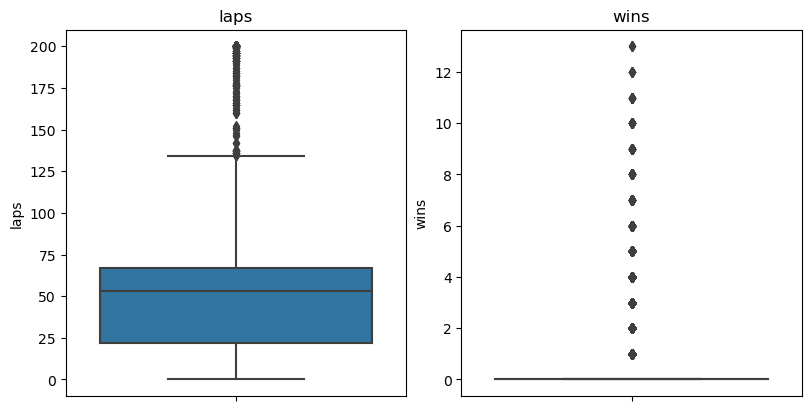

In [21]:
Outliers_vars = ['laps', 'wins']
fig, axes= plt.subplots(nrows= 1, ncols= 2, figsize= (8,4), constrained_layout= True);

for col in Outliers_vars:
    sns.boxplot(y= col, data= merged_data, ax= axes[Outliers_vars.index(col)]);
    axes[Outliers_vars.index(col)].set_title(col);

plt.show();

In [22]:
def find_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

def outlier_trimming (df, variable):
    upper_limit, lower_limit = find_boundaries(df, variable , 1.5)
    trimmed = df[(df[variable] >= lower_limit) & (df[variable] <= upper_limit)]
    return trimmed

After using outlier transformation on 'laps'
![image27](.\images\image-27.png)

Before
> Accuracy: 0.8986088817549491\
Precision: 0.7493403693931399\
Recall: 0.29989440337909185\
F1-Score: 0.42835595776772245

After
> Accuracy: 0.8973250472845177\
Precision: 0.7379679144385026\
Recall: 0.2942430703624733\
F1-Score: 0.42073170731707316

After using capping on 'laps'
![image28](.\images\image-28.png)

Before
> Accuracy: 0.898608881754949\
Precision: 0.7493403693931399\
Recall: 0.29989440337909185\
F1-Score: 0.42835595776772245

After
> Accuracy: 0.8986088817549491\
Precision: 0.752\
Recall: 0.29778247096092925\
F1-Score: 0.426626323751891


After using outlier transformation on 'wins'
![image14](.\images\image-14.png)

Before
> Accuracy: 0.883544987841124\
Precision: 0.7567567567567568\
Recall: 0.11940298507462686\
F1-Score: 0.20626151012891344

After
> Accuracy: 0.946058091286307\
Precision: 0.0\
Recall: 0.0\
F1-Score: 0.0

After using capping on 'wins'
![image15](.\images\image-15.png)

Before
> Accuracy: 0.883544987841124\
Precision: 0.7567567567567568\
Recall: 0.11940298507462686\
F1-Score: 0.20626151012891344

Aftr
> Accuracy: 0.8817887057552013\
Precision: 0.7299270072992701\
Recall: 0.10660980810234541\
F1-Score: 0.18604651162790697

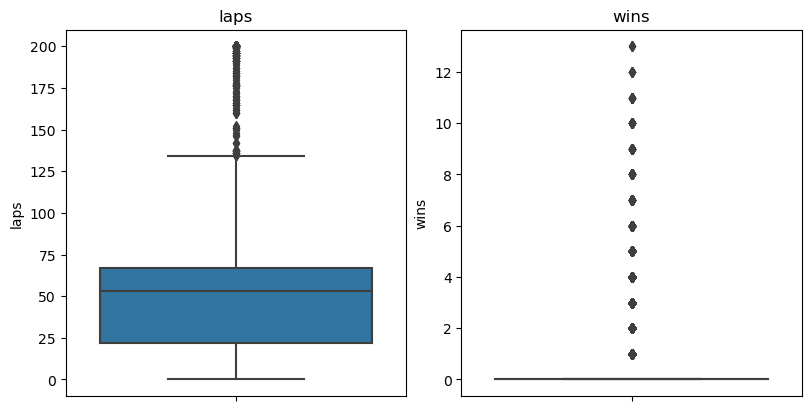

In [23]:
fig, axes= plt.subplots(nrows= 1, ncols= 2, figsize= (8, 4), constrained_layout= True);

for col in Outliers_vars:
    sns.boxplot(y= col, data= merged_data, ax= axes[Outliers_vars.index(col)]);
    axes[Outliers_vars.index(col)].set_title(col);

plt.show();

### Final Decisions and Considerations

wins: 
> Testing across all outlier handling methods proved ineffective and made a negative impact to the distribution. Therefore, it is not transformed to preserve its original value which in itself may prove more valuable for analysis. 

laps: 
> Testing across all outlier handling methods proved ineffective and made a negative impact to the distribution. Therefore, it is not transformed to preserve its original value which in itself may prove more valuable for analysis. 

In [24]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(
     merged_data.drop('podium_finish', axis=1), merged_data['podium_finish'], test_size=0.3, random_state=0)


## Step 3.2: Numerical Transformation

In [25]:
# Looking at the values for each numeric variables
num_cols = [n for n in X_train.columns if X_train[n].dtypes !='O']
for num in num_cols:
    print (f"{num:-^30} ({X_train[num].nunique()})");
    print (X_train[num].value_counts());
    print ("\n");

------------raceId------------ (1057)
800    39
809    36
369    32
361    32
365    31
       ..
274     5
191     5
175     4
158     4
224     3
Name: raceId, Length: 1057, dtype: int64


-----------driverId----------- (790)
8      238
4      218
1      211
22     205
30     199
      ... 
524      1
244      1
472      1
144      1
495      1
Name: driverId, Length: 790, dtype: int64


-------------grid------------- (35)
0     1099
2      755
1      751
7      739
5      739
3      738
4      734
9      732
14     730
10     730
11     730
8      729
6      728
12     721
15     701
13     701
16     690
17     689
18     677
19     653
20     626
21     470
22     453
23     337
24     283
25     219
26     162
27      33
29      18
28      18
31      15
30      15
32      15
33      10
34       1
Name: grid, dtype: int64


-------------laps------------- (165)
0      1688
70      635
53      614
52      531
56      483
       ... 
169       1
170       1
185       1
180       1
16

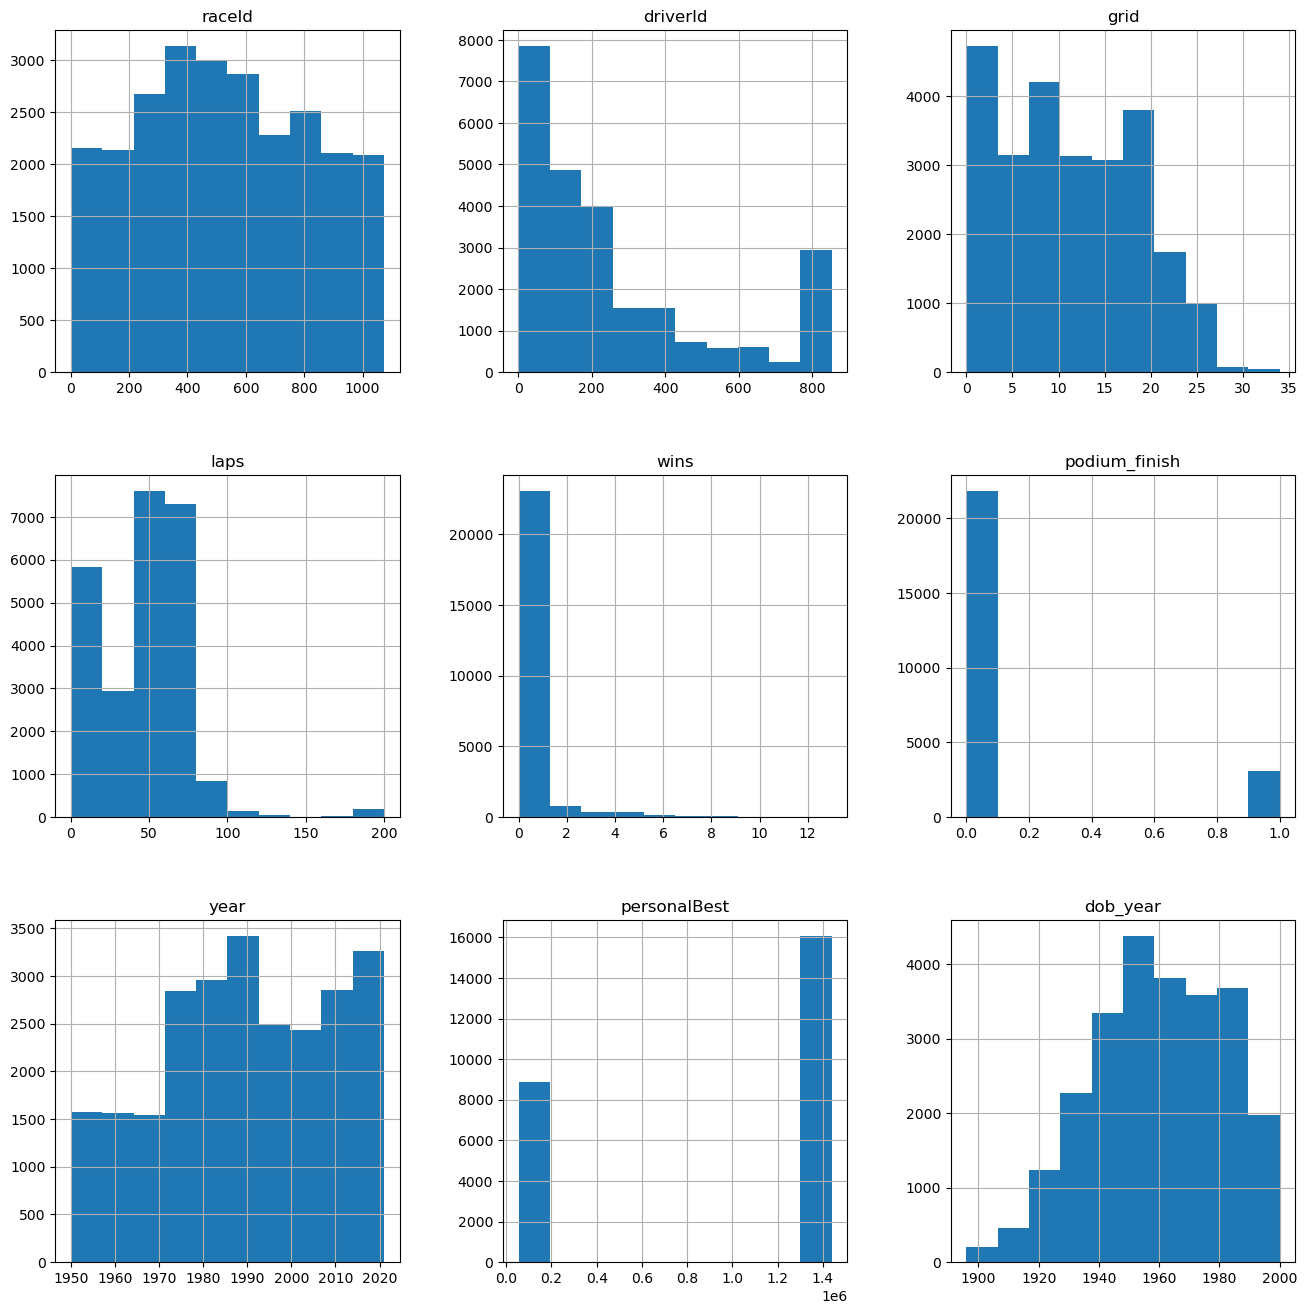

In [26]:
num_cols = [n for n in merged_data.columns if merged_data[n].dtypes!='O']
merged_data.hist(figsize= (16, 16));
plt.show();

In [27]:
# Creating function diagnostic_plots
def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')


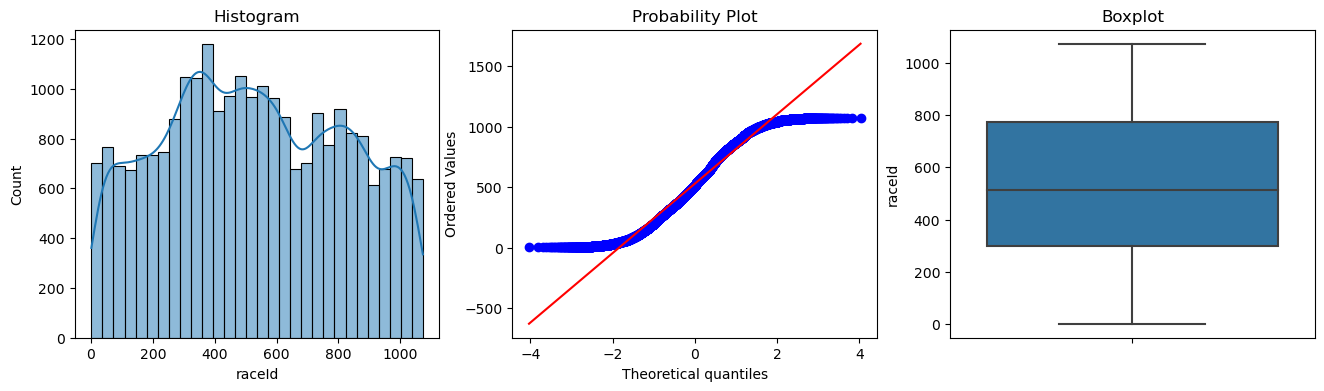

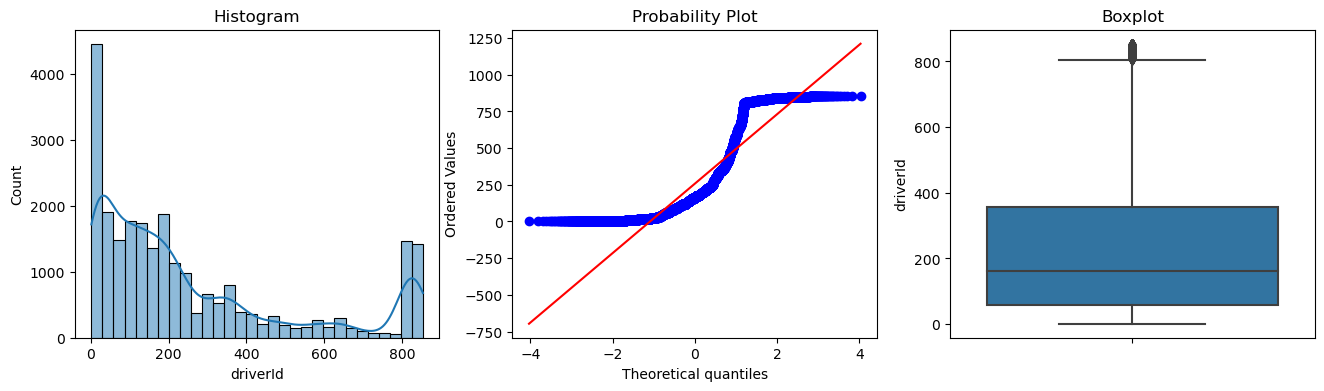

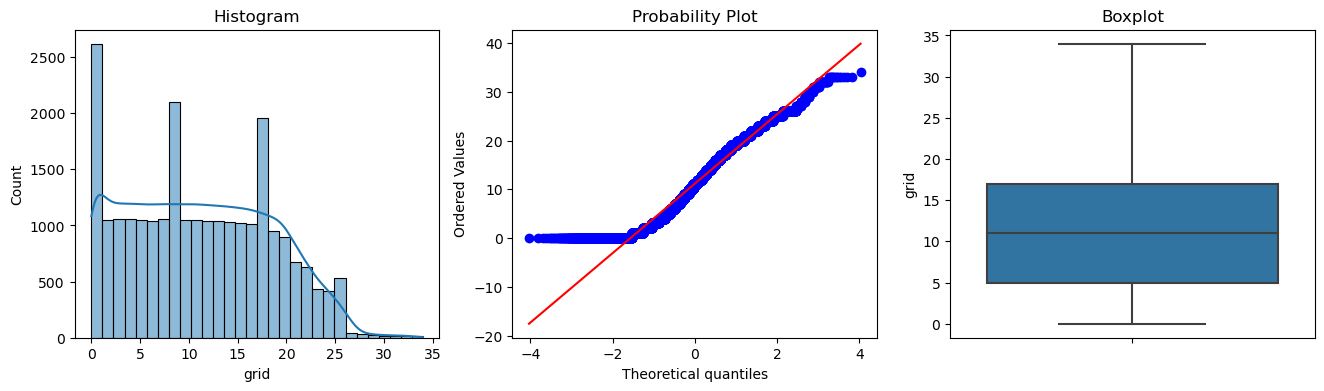

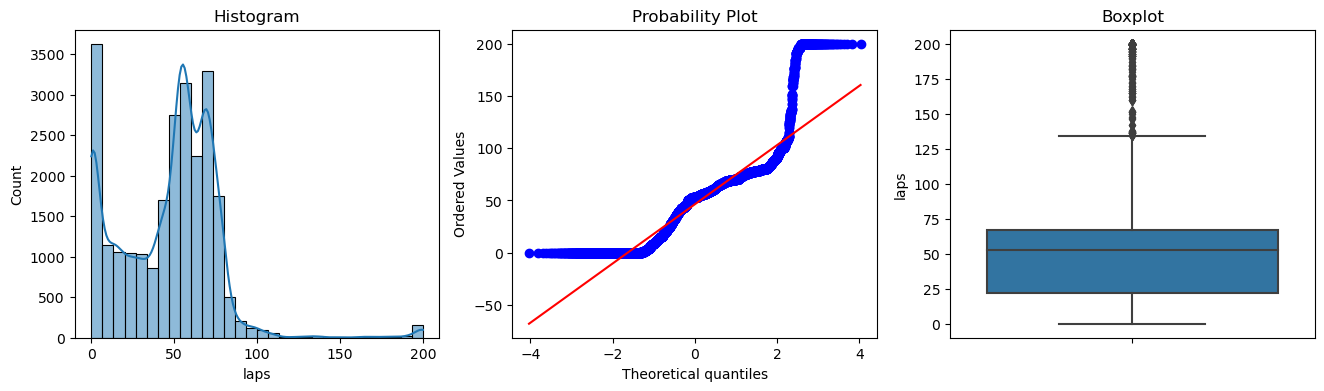

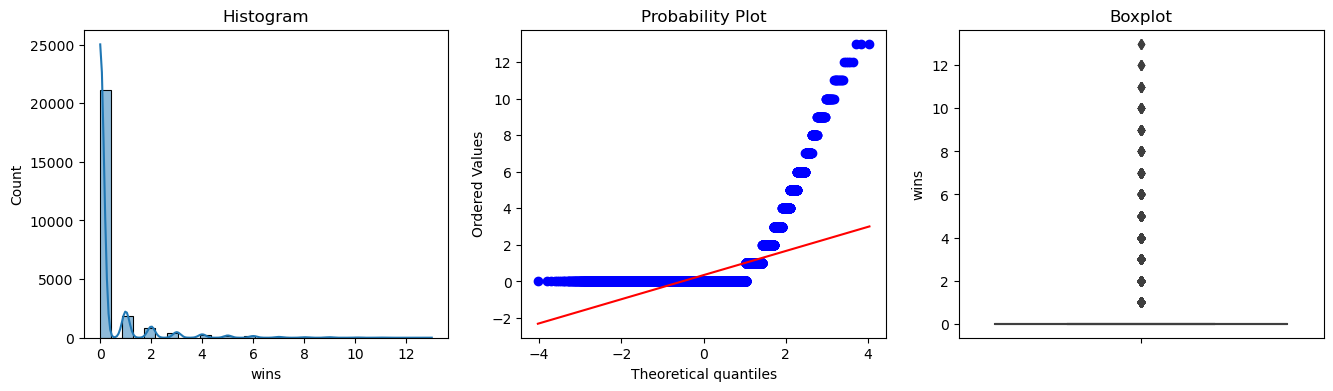

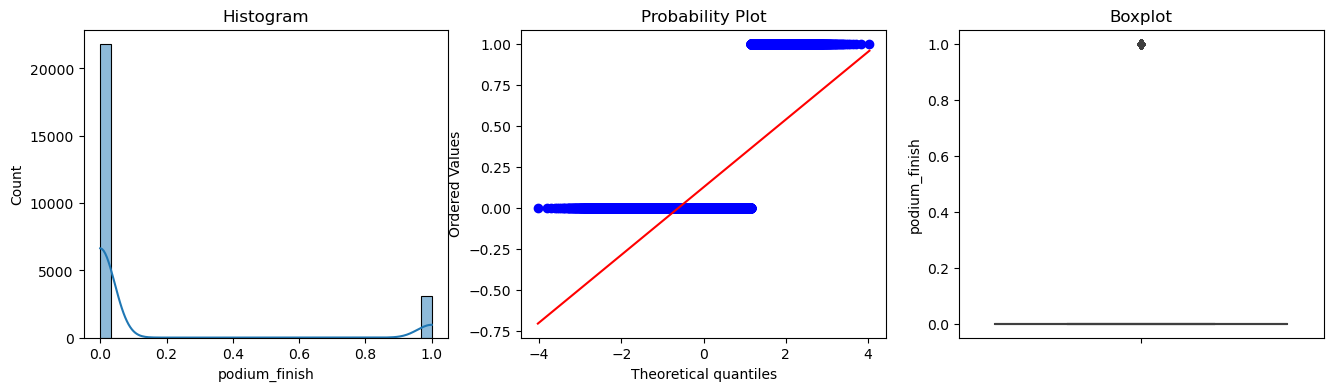

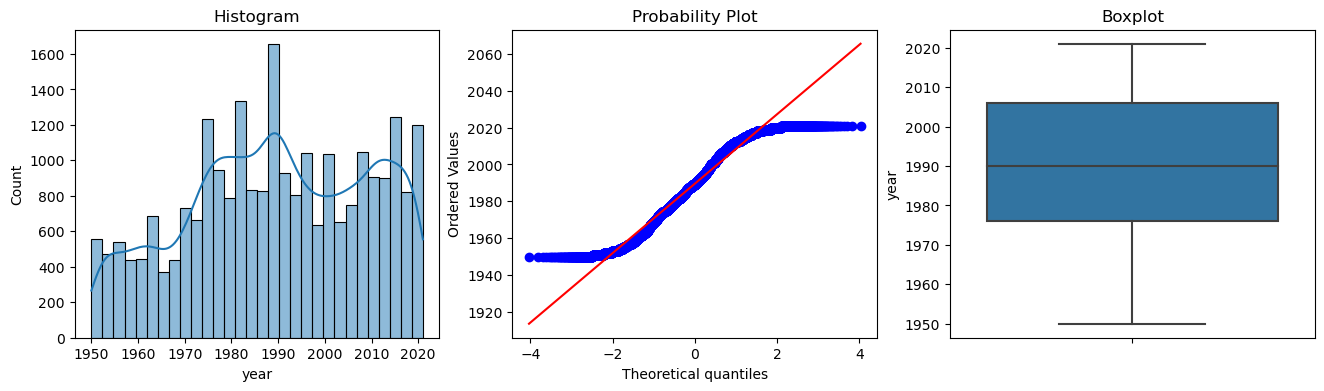

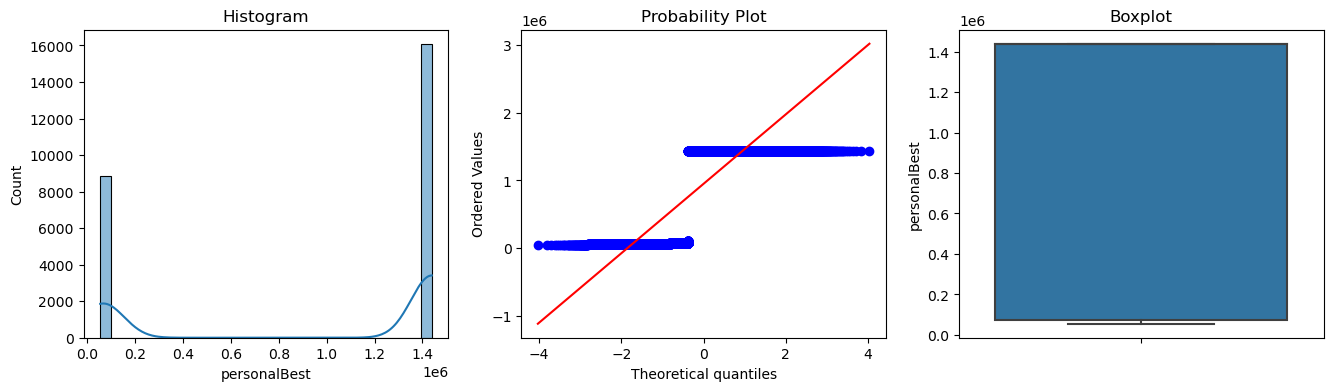

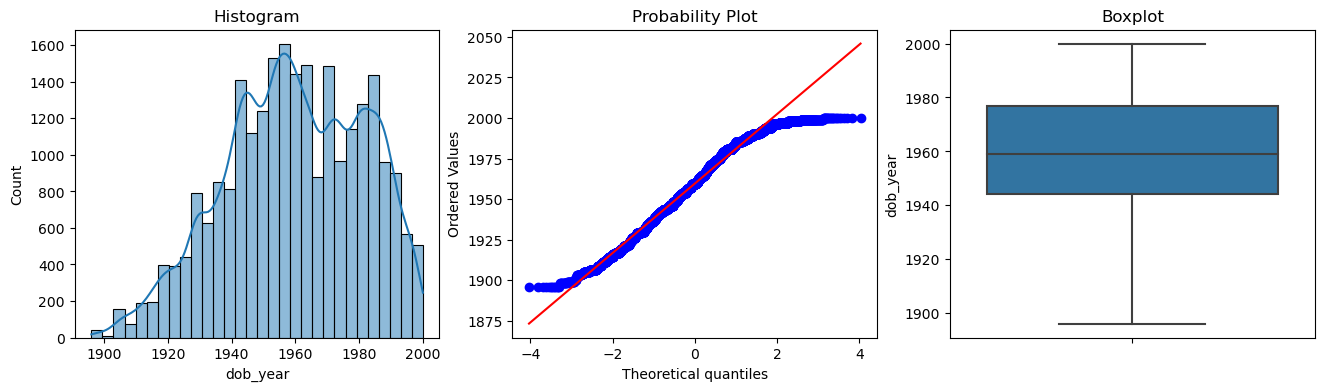

In [28]:
for num in num_cols:
  diagnostic_plots(merged_data, num)

In [29]:
# Creating function transformation processor
def transformation_processor(feature, method, exp=None):
    method= method.lower();
    if method == "log":
        transformer= LogTransformer(variables= feature);
    elif method == "rec":
        transformer= ReciprocalTransformer(variables= feature);
    elif method == "power":
        transformer= PowerTransformer(variables= feature, exp= exp);
    elif method == "box":
        transformer= BoxCoxTransformer(variables= feature);
    elif method == "yeo":
        transformer= YeoJohnsonTransformer(variables= feature);
    else:
        print ("Invalid Numerical Transformation Selected, results may be from previous iteration!");

    transformer.fit(pd.concat([X_train, X_test]));

    trans_testing_set= transformer.transform(pd.concat([X_train, X_test])); 
    
    return trans_testing_set

### Initial Considerations
'podium_finish': No Transformation
> Since 'podium_finish' is a binary variable (0 or 1), it's already in a suitable format for modeling. No transformation is needed.

'raceId', 'driverId': No Transformation
> These are categorical identifiers, and transformations are not applicable.

'grid', 'laps', 'wins'
> Since these variables contain values that are 0, Logarithmic and Box-Cox transformation are not suitable. Square-root trasformation seems visible as it can help moderate effect on distribution. Furthermore, square-root transformation can be applied to zero values.

'dob_year', 'year': Reciprocal Transformation
> Both variables are not skewed and the values are all positive. Therefore, a Reciprocal transformation is the most suitable. It can help to reduce the effect of extreme values and make the distribution more normal.

'personalBest'
>  The variable is high skewed and has a non-normal distribution. Therefore a Log transformation is suitable as the skewness is reduced .

![image1](.\images\image-1.png)
![image2](.\images\image-2.png)

Before
> Accuracy: 0.8810861423220974\
Precision: 0.8085106382978723\
Recall: 0.08025343189017951\
F1-Score: 0.14601344860710855

After
> Accuracy: 0.8810861423220974\
Precision: 0.8085106382978723\
Recall: 0.08025343189017951\
F1-Score: 0.14601344860710855

![image3](.\images\image-3.png)

Before
> Accuracy: 0.8810861423220974\
Precision: 0.8085106382978723\
Recall: 0.08025343189017951\
F1-Score: 0.14601344860710855

After
> Accuracy: 0.8812199036918138\
Precision: 0.8105263157894737\
Recall: 0.08130939809926083\
F1-Score: 0.14779270633397315

![image8](.\images\image-8.png)

Before
> Accuracy: 0.8810861423220974\
Precision: 0.8085106382978723\
Recall: 0.08025343189017951\
F1-Score: 0.14601344860710855

After
> Accuracy: 0.8812199036918138\
Precision: 0.8105263157894737\
Recall: 0.08130939809926083\
F1-Score: 0.14779270633397315

![image7](.\images\image-7.png)

Before
> Accuracy: 0.8812199036918138\
Precision: 0.8105263157894737\
Recall: 0.08130939809926083\
F1-Score: 0.14779270633397315

After
> Accuracy: 0.8792134831460674\
Precision: 0.8142857142857143\
Recall: 0.06019007391763464\
F1-Score: 0.11209439528023599




![image6](.\images\image-6.png)

Before
> Accuracy: 0.8812199036918138\
Precision: 0.8105263157894737\
Recall: 0.08130939809926083\
F1-Score: 0.14779270633397315

After
> Accuracy: 0.8826912787586945\
Precision: 0.8240740740740741\
Recall: 0.09398099260823653\
F1-Score: 0.16872037914691942

![image9](.\images\image-9.png)

Before
> Accuracy: 0.8826912787586945\
Precision: 0.8240740740740741\
Recall: 0.09398099260823653\
F1-Score: 0.16872037914691942

After
> Accuracy: 0.8826912787586945\
Precision: 0.8240740740740741\
Recall: 0.09398099260823653\
F1-Score: 0.16872037914691942

![image30](.\images\image-30.png)

Before
> Accuracy: 0.8987426431246656\
Precision: 0.7595628415300546\
Recall: 0.293558606124604\
F1-Score: 0.4234577303884234

After
> Accuracy: 0.8983413590155164\
Precision: 0.7520215633423181\
Recall: 0.2946145723336853\
F1-Score: 0.4233687405159332

![image31](.\images\image-31.png)

Before
> Accuracy: 0.8987426431246656\
Precision: 0.7595628415300546\
Recall: 0.293558606124604\
F1-Score: 0.4234577303884234

After
> Accuracy: 0.8986088817549491\
Precision: 0.7533512064343163\
Recall: 0.2967265047518479\
F1-Score: 0.4257575757575757

![image32](.\images\image-32.png)

Before
> Accuracy: 0.8987426431246656\
Precision: 0.7595628415300546\
Recall: 0.293558606124604\
F1-Score: 0.4234577303884234

After
> Accuracy: 0.8982075976457999\
Precision: 0.7486631016042781\
Recall: 0.29567053854276665\
F1-Score: 0.42392127176381533

### Final Decisions and Considerations
raceId &rarr; Not Transformed <br>
driverId &rarr; Not Transformed <br>
podium_finish &rarr; Not Transformed <br>
grid &rarr; Not Transformed <br>
wins &rarr; Not Transformed <br>
year &rarr; Not Transformed <br>
personalBest &rarr; Not Transformed <br>
laps &rarr; YeoJohnson Transformation <br>
dob_year &rarr; Reciprocal Transformation <br>


### Observations

grid, wins
> Testing across all transformation methods proved ineffective and made no significant impact to the distribution. Therefore, it is not transformed to preserve its original value which in itself may prove more valuable for analysis.

year
> While this type of distribution is often extremely difficult to transform, I could apply Yeo Johnson transformation to suppress the extreme tails and elavate the middle distribution, making it slightly more normal. However, further analysis revealed that applying such transformation had no impact. Furthermore, testing using reciprocal transformation proved ineffective and made a negative impact to the distribution. Thus, no transformation was applied to this feature.

laps
> By applying Yeo Johnson transformation I can suppress the extreme tails and elavate the middle distribution. Therefore, Yeo Johnson transformation was applied to this feature.

dob_year
> By applying Reciprocal transformation I can increase skewness and improve distribution. Therefore, Reciprocal transformation was applied to this feature.

personalBest
> While this type of distribution seem to have multiple ways of transformation, I decided to use power transformation to moderate effect on distribution. With that, I can minimise its skewness and improve distribution. Therefore, power transformation was applied to this feature.

In [30]:
# Transformation pipeline
pipe= Pipeline(steps=[
    ('yeo_johnson_trans', YeoJohnsonTransformer(variables= ['laps'])),
    ('reciprocal_trans', ReciprocalTransformer(variables= ['dob_year'])),
    ('power', PowerTransformer(variables= ['personalBest'])),
]);

pipe.fit(pd.concat([X_train, X_test]));

In [31]:
trans_X_train= pipe.transform(X_train);
trans_X_test= pipe.transform(X_test);

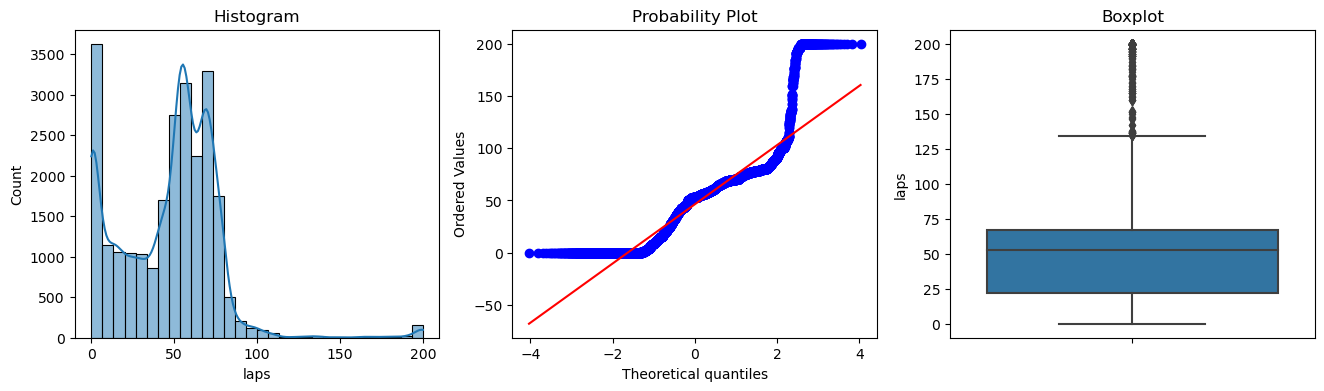

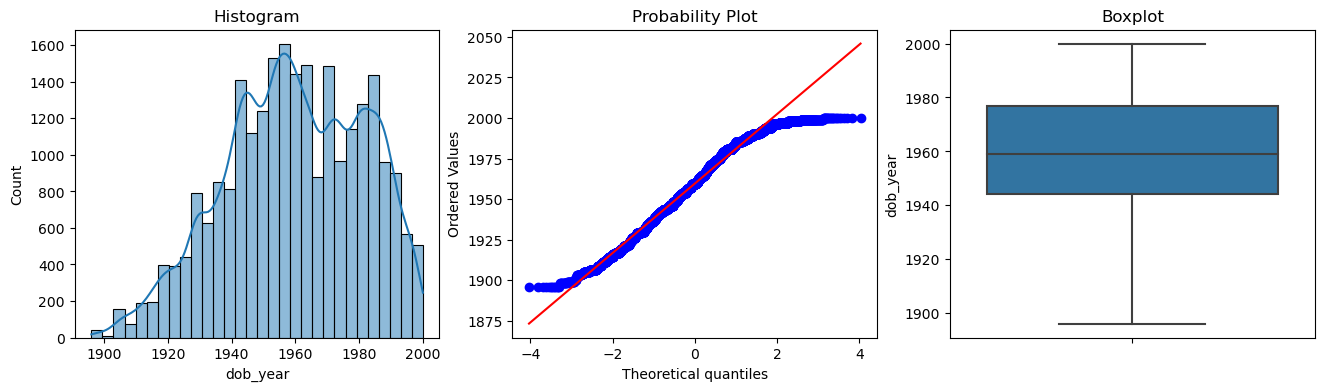

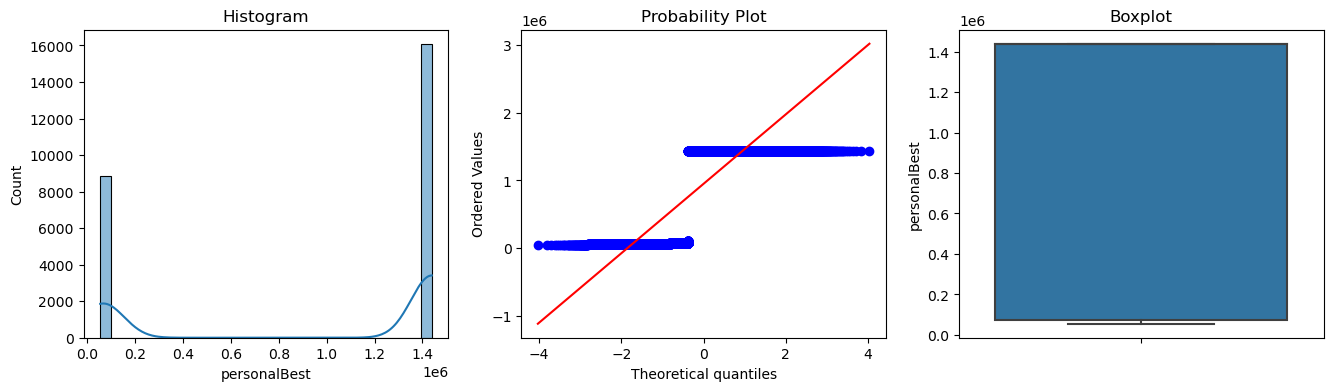

In [32]:
for var in ['laps','dob_year','personalBest']:
  diagnostic_plots(merged_data, var)

## Step 3.2: Categorical Transformation

In [33]:
# Looking at the values for each categorical variables
cat_cols = [c for c in trans_X_train.columns if trans_X_train[c].dtypes=='O']
for cat in cat_cols:
    print (f"{cat:-^30} ({trans_X_train[cat].nunique()})");
    print (trans_X_train[cat].value_counts());
    print ("\n");

-----------country------------ (34)
Italy           1732
USA             1349
Germany         1349
UK              1305
Monaco          1132
Belgium         1073
France          1053
Spain            939
Canada           862
Brazil           730
Japan            630
Austria          609
Hungary          598
Netherlands      496
Australia        482
South Africa     380
Mexico           323
Portugal         315
Argentina        295
Malaysia         274
Bahrain          264
China            233
UAE              188
Singapore        174
Turkey           129
Russia           116
Sweden           114
Azerbaijan        72
Switzerland       66
Korea             66
India             48
Morocco           17
Saudi Arabia      16
Qatar             12
Name: country, dtype: int64


---------nationality---------- (41)
British              2964
Italian              2342
French               2084
German               1596
Brazilian            1290
American              894
Finnish               789
Au

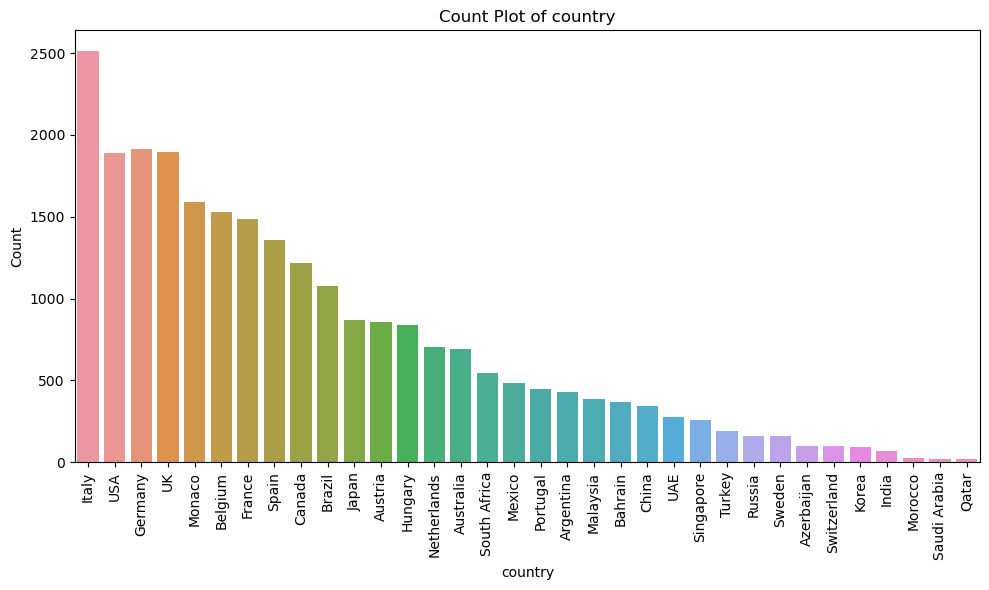

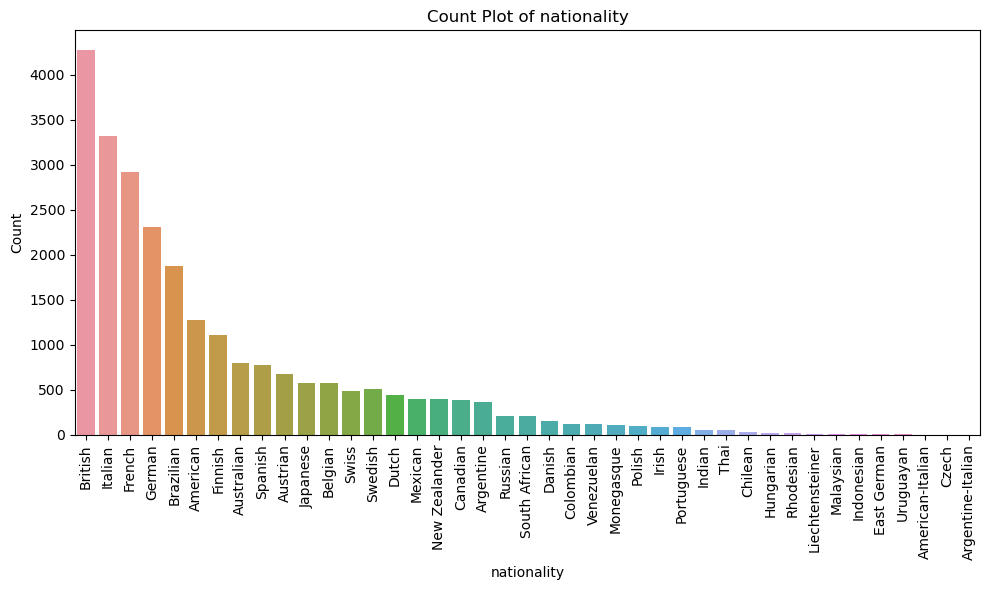

In [34]:
for cat in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=merged_data, x=cat, order=trans_X_train[cat].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Count Plot of {cat}')
    plt.xlabel(cat)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### Encoding methods chosen:<br><br>
'country', 'nationality':<br>
Encoding Method:
> One-Hot Encoding<br>
Explanation: Since both variables are nominal categorical variables (Do not have a specific order or hierarchy), one-hot encoding would be the most suitable option

In [35]:
# One-Hot Encoding
ohe_enc = OneHotEncoder(variables=['country', 'nationality'],top_categories=None)
ohe_enc.fit(X_train)
ohe_X_train = ohe_enc.transform(trans_X_train)
ohe_X_test = ohe_enc.transform(trans_X_test)

## Step 3.3: Variable Discretisation / Binning

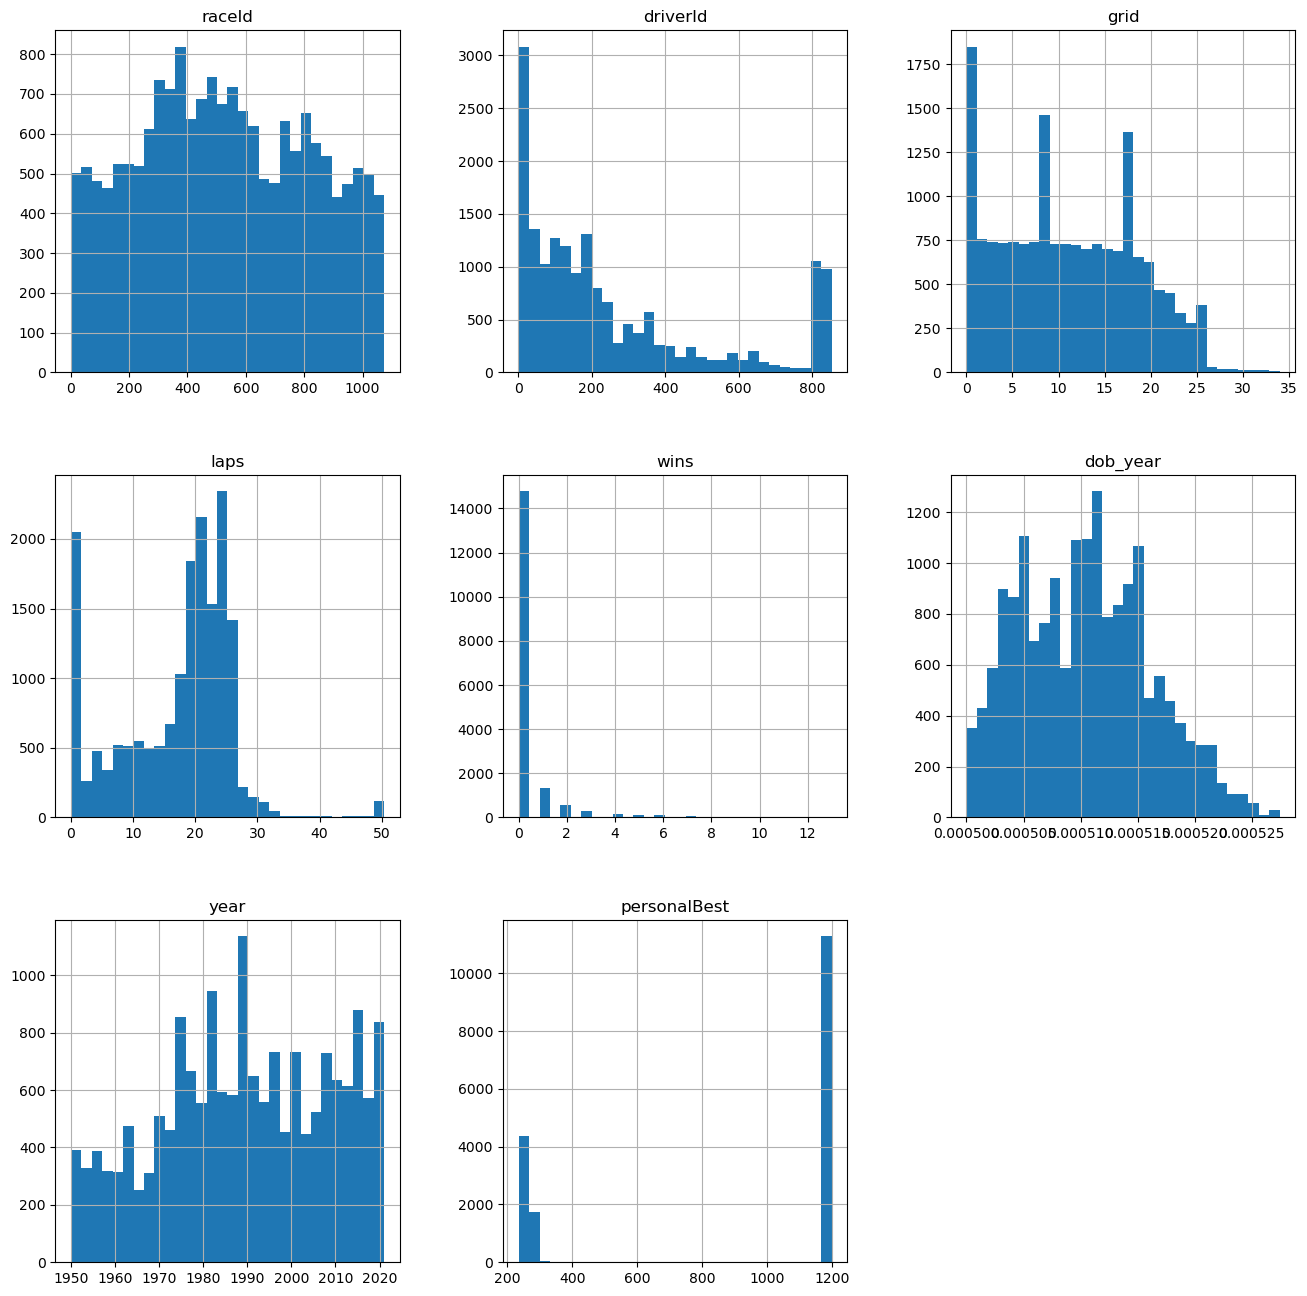

In [36]:
# variables = ['raceId','driverId', 'grid', 'laps', 'fastestLap', 'wins', 'dob_year', 'year', 'fastestLapTime_ms']
# ohe_X_train[variables].hist(figsize= (16, 16), bins= 30);
# plt.show();
variables = ['raceId','driverId', 'grid', 'laps', 'wins', 'dob_year', 'year', 'personalBest']
ohe_X_train[variables].hist(figsize= (16, 16), bins= 30);
plt.show();

In [37]:
def bins_observation(feature):
    t1 = ohe_X_train.groupby([feature])[feature].count() / len(ohe_X_train)
    t2 = ohe_X_test.groupby([feature])[feature].count() / len(ohe_X_test)
    
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar()
    plt.xticks(rotation=0)
    plt.ylabel('Number of observations per bin')

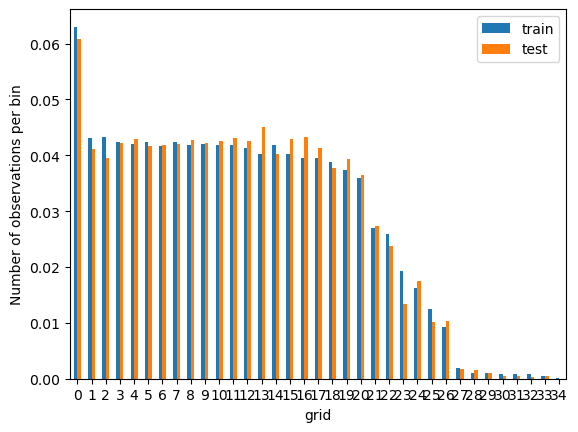

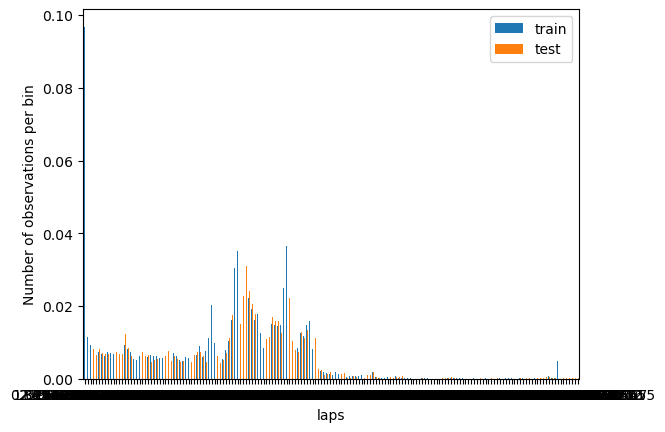

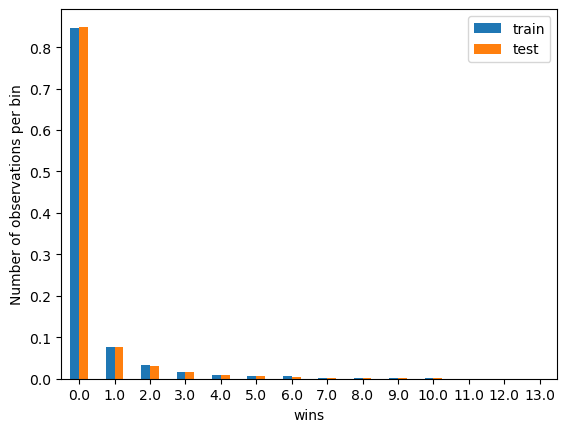

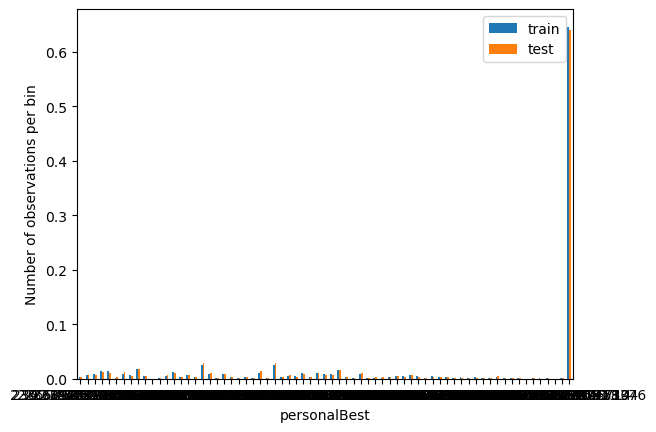

In [38]:
bins_observation('grid')
bins_observation('laps')
bins_observation('wins')
bins_observation('personalBest')


### Initial Considerations
raceId and driverId:
> These variables are categorical identifiers. Thus, they don't need discretization.

laps, wins:
> I decided to use Equal Frequency discretization as the data distribution contains outliers and I want to ensure that each bin represents a similar portion of the data.

personalBest, dob_year and year:
> I decided to use Equal Width discretization as I felt that the data can be discretized into  time periods.

grid:
> I decided to use Equal Width discretization as data is fairly uniform and I want to simplify visualizations or reduce the number of data points for analysis.

After using Equal Frequency on laps
![image18](.\images\image-18.png)

Before
> Accuracy: 0.883544987841124\
Precision: 0.7567567567567568\
Recall: 0.11940298507462686\
F1-Score: 0.20626151012891344

After
> Accuracy: 0.8798973250472846\
Precision: 0.7024793388429752\
Recall: 0.0906183368869936\
F1-Score: 0.16052880075542963


After using Equal Frequency on fastestLap
![image19](.\images\image-19.png)

Before
> Accuracy: 0.883544987841124\
Precision: 0.7567567567567568\
Recall: 0.11940298507462686\
F1-Score: 0.20626151012891344

After
> Accuracy: 0.8843555795730883\
Precision: 0.759493670886076\
Recall: 0.1279317697228145\
F1-Score: 0.21897810218978103

After using Equal Frequency on wins
![image20](.\images\image-20.png)

Before
> Accuracy: 0.883544987841124\
Precision: 0.7567567567567568\
Recall: 0.11940298507462686\
F1-Score: 0.20626151012891344

After
> Accuracy: 0.8874628478789517\
Precision: 0.8070175438596491\
Recall: 0.14712153518123666\
F1-Score: 0.24887285843101892

After using Equal Width on grid
![image22](.\images\image-22.png)

Before
> Accuracy: 0.8874628478789517\
Precision: 0.8070175438596491\
Recall: 0.14712153518123666\
F1-Score: 0.24887285843101892

After
> Accuracy: 0.8828694947311537\
Precision: 0.7553956834532374\
Recall: 0.11194029850746269\
F1-Score: 0.19498607242339835

After using Equal Width on fastestLapTime_ms
![image23](.\images\image-23.png)

Before
> Accuracy: 0.8874628478789517\
Precision: 0.8070175438596491\
Recall: 0.14712153518123666\
F1-Score: 0.24887285843101892

After
> Accuracy: 0.8828694947311537\
Precision: 0.7553956834532374\
Recall: 0.11194029850746269\
F1-Score: 0.19498607242339835

After using Equal Width on date
![image26](.\images\image-26.png)

Before
> Accuracy: 0.8874628478789517\
Precision: 0.8070175438596491\
Recall: 0.14712153518123666\
F1-Score: 0.24887285843101892

After
> Accuracy: 0.8889489327208863\
Precision: 0.8020833333333334\
Recall: 0.16417910447761194\
F1-Score: 0.27256637168141595

After using Equal Width 5 on dob_year
![image25](.\images\image-25.png)

Before
> Accuracy: 0.8874628478789517\
Precision: 0.8070175438596491\
Recall: 0.14712153518123666\
F1-Score: 0.24887285843101892

After
> Accuracy: 0.8889489327208863\
Precision: 0.8020833333333334\
Recall: 0.16417910447761194\
F1-Score: 0.27256637168141595

After using Equal Width on personalBest
![image34](.\images\image-34.png)

Before
> Accuracy: 0.8987426431246656\
Precision: 0.7595628415300546\
Recall: 0.293558606124604\
F1-Score: 0.4234577303884234

After
> Accuracy: 0.8979400749063671\
Precision: 0.7486486486486487\
Recall: 0.2925026399155227\
F1-Score: 0.4206529992406986

### Final Decisions and Considerations<br>
laps &rarr; Not Transformed <br>
grid &rarr; Not Transformed <br>
personalBest &rarr; Not Transformed <br>
wins &rarr; Equal Frequency <br>
year &rarr; Equal Width <br>
dob_year &rarr; Equal Width 5

laps, grid, personalBest:
> Testing with various transformation methods proved ineffective and made a negative impact to the distribution. Therefore, it is not transformed to preserve its original value which in itself may prove more valuable for analysis.

wins:
> By applying Equal Frequency discretization it can handle outliers as the values are divided into bins such that each bin contains approximately the same number of data points. Therefoe, Equal Frequency discretization is applied to this feature

dob_year and year:
> By applying Equal Width discretization the data can be discretized into  time periods as the values are divided into bins, each with the same width. Therefoe, Equal Width discretization is applied to this feature

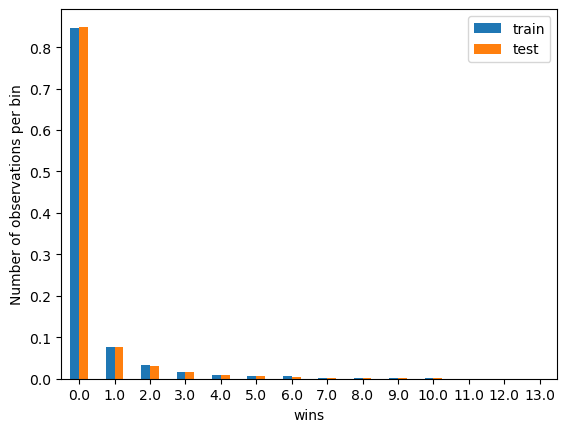

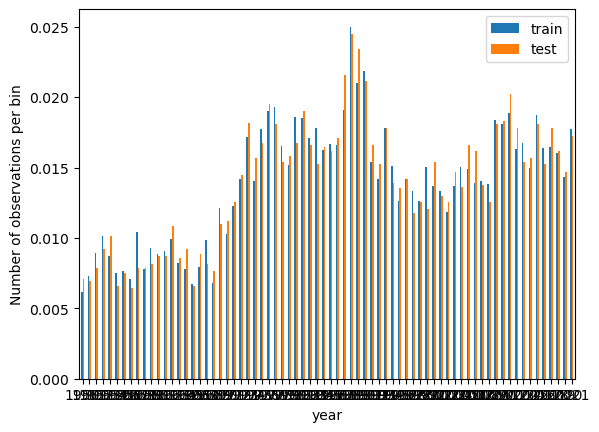

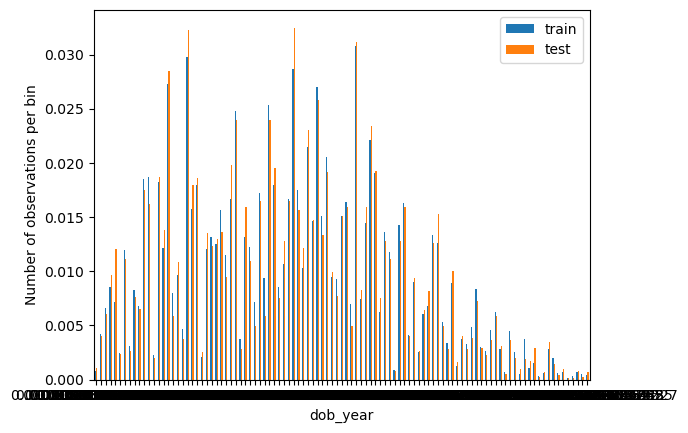

In [39]:
pipe= Pipeline(steps=[
    ('Equal Freq', EqualFrequencyDiscretiser(variables= ['wins'])),
    ('Equal Width', EqualWidthDiscretiser(variables= ['year'])),
    ('Equal Width 5', EqualWidthDiscretiser(variables= ['dob_year'], bins = 5))
]);
bins_observation('wins')
bins_observation('year')
bins_observation('dob_year')

pipe.fit(ohe_X_train);
disc_X_train= pipe.transform(ohe_X_train);
disc_X_test= pipe.transform(ohe_X_test);

## Step 3.3: Feature Engineer

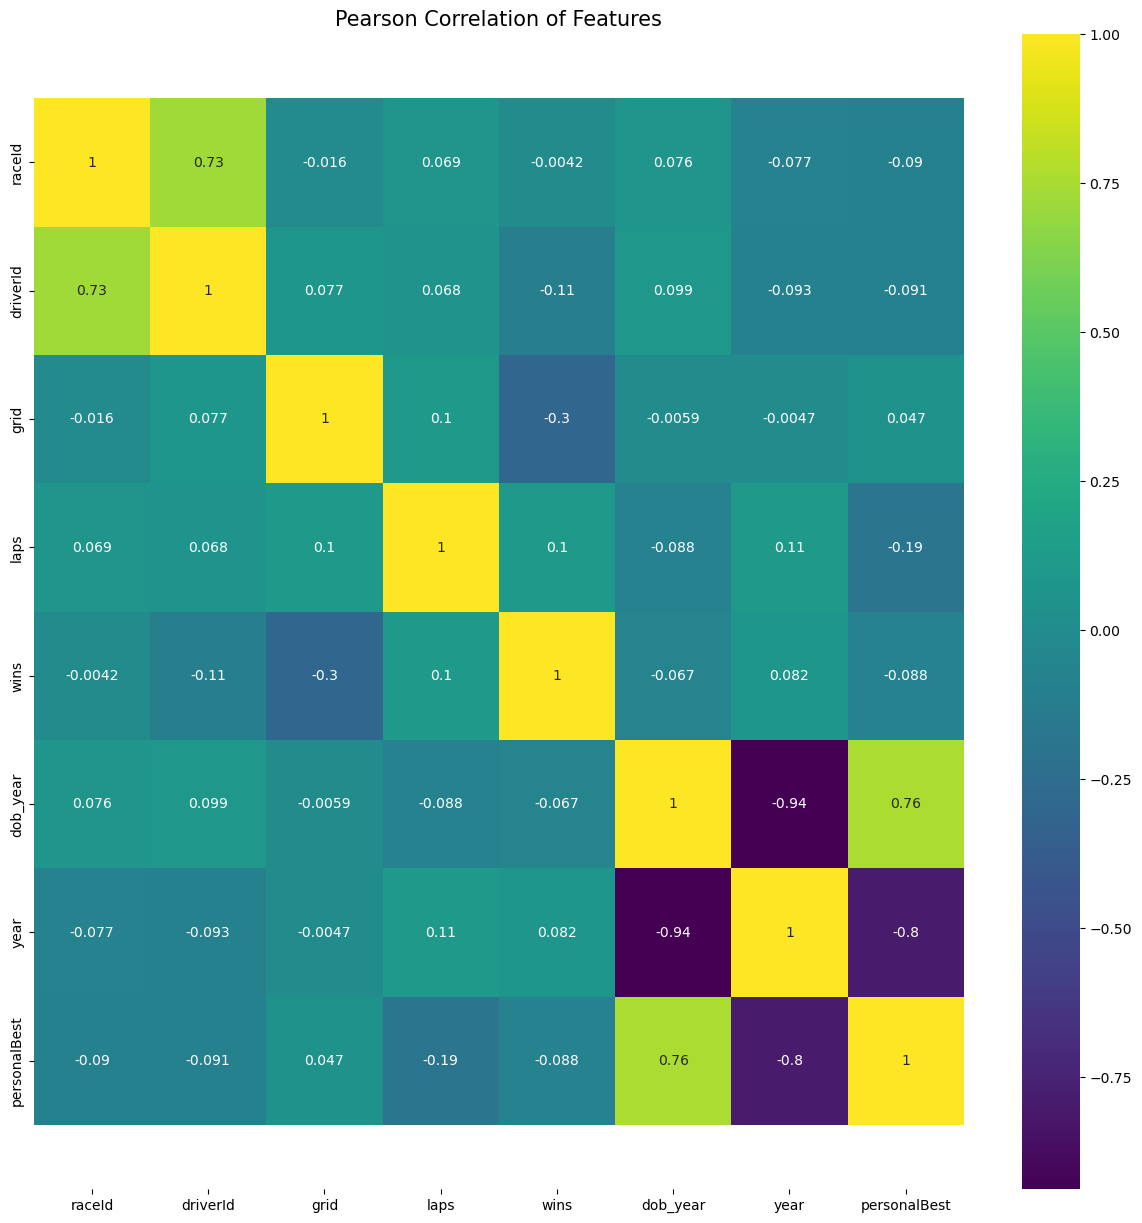

In [40]:
# Heatmap: visualize the correlation between any two features / variables
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(disc_X_train[variables].astype(float).corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [41]:
X_train = disc_X_train
X_test = disc_X_test


### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear') # you can experiment with different combinations of multi_class and solver
# logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs') # good option for larger datasets, fails here
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [43]:
y_train_preds_logreg = logreg.predict(X_train)
y_test_preds_logreg = logreg.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score

# train accuracy score
y_true = y_train
y_pred = y_train_preds_logreg

train_accuracy_logreg = accuracy_score(y_true, y_pred) * 100
print(f"The LogReg Model's accuracy on train data is {train_accuracy_logreg:.2f}%.")

# test accuracy score
y_true = y_test
y_pred = y_test_preds_logreg

test_accuracy_logreg = accuracy_score(y_true, y_pred) * 100
print(f"The LogReg Model's accuracy on test data is {test_accuracy_logreg:.2f}%.")

The LogReg Model's accuracy on train data is 90.23%.
The LogReg Model's accuracy on test data is 90.42%.


#### Standard Scaler

In [45]:
# Standardization
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logreg_ss = LogisticRegression(multi_class='multinomial', solver='lbfgs') # seems to work here after scaling
logreg_ss.fit(X_train_scaled, y_train)

LogisticRegression(multi_class='multinomial')

In [46]:
y_train_preds_logreg_ss = logreg_ss.predict(X_train_scaled)

# insert code here
y_test_preds_logreg_ss = logreg_ss.predict(X_test_scaled)

In [47]:
# train accuracy score
y_true = y_train
y_pred = y_train_preds_logreg_ss

train_accuracy_logreg_ss = accuracy_score(y_true, y_pred) * 100
print(f"The LogRegSS Model's accuracy on train data is {train_accuracy_logreg_ss:.2f}%.")

# test accuracy score
y_true = y_test
y_pred = y_test_preds_logreg_ss

test_accuracy_logreg_ss = accuracy_score(y_true, y_pred) * 100
print(f"The LogRegSS Model's accuracy on test data is {test_accuracy_logreg_ss:.2f}%.")

The LogRegSS Model's accuracy on train data is 90.36%.
The LogRegSS Model's accuracy on test data is 90.54%.


In [48]:
classification_col_labels = disc_X_train.columns
classification_col_labels

Index(['raceId', 'driverId', 'grid', 'laps', 'wins', 'year', 'personalBest',
       'dob_year', 'country_Monaco', 'country_Belgium', 'country_Germany',
       'country_Russia', 'country_UAE', 'country_Portugal', 'country_Austria',
       'country_China', 'country_France', 'country_USA', 'country_UK',
       'country_Australia', 'country_South Africa', 'country_Mexico',
       'country_Malaysia', 'country_Japan', 'country_Spain', 'country_Brazil',
       'country_Bahrain', 'country_Italy', 'country_Netherlands',
       'country_Argentina', 'country_Hungary', 'country_Canada',
       'country_Singapore', 'country_Switzerland', 'country_Azerbaijan',
       'country_Turkey', 'country_Korea', 'country_Morocco', 'country_Sweden',
       'country_Qatar', 'country_India', 'country_Saudi Arabia',
       'nationality_Finnish', 'nationality_Spanish', 'nationality_Brazilian',
       'nationality_Australian', 'nationality_British', 'nationality_French',
       'nationality_Austrian', 'nationality_G

In [49]:
logreg_ss_importance = logreg_ss.coef_
logreg_ss_importance

array([[ 5.01742591e-02, -1.46402752e-01, -1.06341658e+00,
         8.40757984e-01,  1.44532439e-01, -3.15302507e-02,
         3.81214009e-02,  4.30246330e-02, -4.84550924e-02,
         1.12725806e-01,  9.88221826e-02,  7.10138949e-03,
         6.84902967e-03, -1.76235166e-02,  1.45025723e-02,
         9.96992684e-03, -3.67293977e-03, -1.31669542e-01,
        -1.41851075e-02,  2.65715314e-02, -3.19501829e-02,
        -3.69196421e-02,  2.17305738e-02,  8.09294310e-03,
        -9.02600184e-03,  7.68964692e-03,  1.24686043e-02,
         5.90778430e-02, -2.70186874e-02,  1.48829853e-03,
        -5.71712242e-02, -2.99892861e-02, -6.93860164e-03,
         2.58795316e-02,  1.60189623e-02,  4.09925350e-03,
        -1.97632265e-04,  1.80906856e-02, -1.24263977e-02,
        -9.66928941e-02, -1.12688015e-02,  1.21603308e-02,
         5.33793088e-02,  2.27315647e-02,  2.04655881e-02,
         1.77460885e-02,  4.45668108e-02,  3.30070430e-02,
         2.14097810e-02,  2.04781565e-02, -1.16324215e-0

In [50]:
# reorganize into dataframe
df_logreg_ss_feature_importance = pd.DataFrame(classification_col_labels, columns=["feature"])
df_logreg_ss_feature_importance["importance"] = logreg_ss_importance[0]
df_logreg_ss_feature_importance

,feature,importance
0,raceId,0.050174
1,driverId,-0.146403
2,grid,-1.063417
3,laps,0.840758
4,wins,0.144532
...,...,...
78,nationality_Indonesian,-0.033246
79,nationality_Chilean,-0.087562
80,nationality_American-Italian,-0.029032
81,nationality_Czech,-0.018488


In [51]:
threshold = 0.05  # You can adjust this value

# Identify low-importance features
low_importance_features = df_logreg_ss_feature_importance[
    (df_logreg_ss_feature_importance['importance'] <= 0.05) &
    (df_logreg_ss_feature_importance['importance'] >= -0.05)
]['feature']

# Drop low-importance columns
X_train_selected = disc_X_train.drop(low_importance_features, axis=1)
X_test_selected = disc_X_test.drop(low_importance_features, axis=1)


In [52]:
for col in X_train_selected:
    print(X_train_selected[col].value_counts())

800    39
809    36
369    32
361    32
365    31
       ..
274     5
191     5
175     4
158     4
224     3
Name: raceId, Length: 1057, dtype: int64
8      238
4      218
1      211
22     205
30     199
      ... 
524      1
244      1
472      1
144      1
495      1
Name: driverId, Length: 790, dtype: int64
0     1099
2      755
1      751
7      739
5      739
3      738
4      734
9      732
14     730
10     730
11     730
8      729
6      728
12     721
15     701
13     701
16     690
17     689
18     677
19     653
20     626
21     470
22     453
23     337
24     283
25     219
26     162
27      33
29      18
28      18
31      15
30      15
32      15
33      10
34       1
Name: grid, dtype: int64
0.000000     1688
24.367134     635
20.041797     614
19.774280     531
20.834688     483
             ... 
44.873449       1
45.055658       1
47.747932       1
46.858788       1
43.587874       1
Name: laps, Length: 165, dtype: int64
0    16095
1     1346
Name: wins, dtype:

### Polynomial Expansion

In [53]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

poly.fit(X_train_selected)

X_train = poly.transform(X_train_selected)
X_test = poly.transform(X_test_selected)

In [54]:
poly_features= pd.DataFrame(X_train.copy(), columns= poly.get_feature_names_out());
poly_features['podium_finish']= y_train;

poly_corrs= poly_features.corr()['podium_finish'].sort_values()

print (poly_corrs);

wins country_Germany                        -0.029431
raceId driverId                             -0.020164
raceId^2                                    -0.018962
driverId                                    -0.018262
driverId^2                                  -0.017779
                                               ...   
nationality_Hungarian nationality_Indian          NaN
nationality_Hungarian nationality_Chilean         NaN
nationality_Irish nationality_Indian              NaN
nationality_Irish nationality_Chilean             NaN
nationality_Indian nationality_Chilean            NaN
Name: podium_finish, Length: 210, dtype: float64


<a id= "4"></a>
# Step 4: Machine Learning Modelling
[Go to Start](#Start)

In [55]:
# Naive baseline model
from sklearn.metrics import accuracy_score
# Naive Baseline: Always predict the majority class in the training set
majority_class = y_train.value_counts().idxmax()
naive_predictions = [majority_class] * len(X_test)

# Calculate accuracy of the naive baseline model
accuracy = accuracy_score(y_test, naive_predictions)

print(f'Naive Baseline Accuracy: {accuracy:.2f}')

Naive Baseline Accuracy: 0.87


In [56]:
# Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = RandomForestClassifier(max_depth = 7, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8984751203852327
Precision: 0.7435233160621761
Recall: 0.30306230200633577
F1-Score: 0.43060765191297823


<a id= "5"></a>
# Report
[Go to Start](#Start)

<a id= "6"></a>
## 1. Table of Content

1. [Table of Content](#6)
2. [Introduction with Value Based Problem Statement](#7)
3. [Problem Formulation](#8)
4. [Data Wrangling on multiple tables](#9)
5. [Data Cleansing and Transformation](#10)
6. [Machine Learning Model](#11)
7. [Summary and Further Improvements](#12)

<a id= "7"></a>
## 2. Introduction with Value Based Problem Statement
In this section, the aim is to pique the reader's interest, underline the relevance of the issue, and pave the way for discussions.

### Introduction:
This introduction is crucial to the project since it determines whether a driver will finish in the top three in a forthcoming race. With its thrilling performances and fast-paced races, the world of racing has a lot of attraction. As a fan of F1 races, I always sought after the top 3 finishes and often compete with others on the prediction of the podium. The difficulty, though, lies in correctly forecasting which drivers will get these top places.

### The Value Based Problem Statement:
The Value Based Problem Statement presented here focuses on our primary objective: developing a model capable of forecasting a driver's chances of placing on the podium in an upcoming race. The significance of this endeavour is felt by everyone involved in the racing industry, including teams, bettors, commentators, and fans. An accurate predictive model might have far-reaching effects, possibly changing race tactics and improving betting forecasts.

### Complexity of our dataset:
Our approaches to data wrangling and transformation, as well as the machine learning methods used for predicting insights, will all be covered in more detail in the next sections. The core of our study goes beyond the binary values of race results, exploring the complexities of predictive modelling for an F1 race.

### Conclusion:
In conclusion, the Introduction with Value-Based Problem Statement acts as a compass, directing readers to the significance and relevance of my effort. In this report, we will emphasize the practical implications of our pursuit by presenting the challenge of predicting podium finishes. This part establishes a connection between the fascination of F1 races and the investigation of data-driven insights.


<a id= "8"></a>
## 3. Problem Formulation
This study sets out on a quest to explore the complexities of this value-based task, demonstrating the processes taken to load and analyse the data and, in the end, to create a prediction problem that captures the essence of F1 competitiveness.

### Loading and Exploring the Data:
The collection and loading of various datasets that collectively define the environment of F1 competitions is the first step in addressing this challenge. The prediction model's insights are made up of race history, driver profiles, team performance, course features, and season conditions. These various components can be combined to create a thorough perspective of the racing system, which serves as a basis for building the prediction problem.

### Understanding the Data:
To uncover significant trends and insights that influence podium results, a thorough analysis of the data is required. Each dataset tells a narrative; factors such as the track record of the driver, the constructor standings, the location of the track, and the seasons all have a significant impact on the result. The dynamics of the data are shown via visualizations, summary statistics, and exploratory analysis, which enables the discovery of trends that may help formulate the prediction problem.

### Formulating a Prediction Problem:
The development of a prediction problem aims to capture the crux of F1 competitiveness. The challenge is developing a model that can forecast whether a driver will place among the top three in a forthcoming race. With that, I hope to understand the complex interactions of factors that affect podium success. The key to solving the prediction problem is to build features that encompass a driver's previous performance, drivers’ particulars, drivers’ starting position, and other variables that affect race results.

### Approaches and Considerations:
The complexity of racing competition emerges as the problem formulation process progresses. Strategic choices, weather variations, technological difficulties, and driver psychology, adds levels of unpredictability to the assignment. In order to create a problem that captures the spirit of racing while allowing the predictive model to identify the underlying patterns, the formulation process must take these factors into account.

### Conclusion:
In conclusion, the process of formulating the problem, investigating the data, and developing the prediction problem demonstrates the complexity of predicting podium positions in F1 race. The importance of knowing the details of the data and converting them into a predictive framework has been reinforced in this report. The report lays the foundation for the subsequent phases, when data wrangling, cleaning, and model development takes place, as the assignment progresses. The complex methods that led to the creation of the predictive model will shed light on the top three finishers in a setting where milliseconds and careful moves can be the difference between winning and losing.


<a id= "9"></a>
## 4. Data Wrangling on multiple tables
Predictive modelling for podium finishes in F1 races requires pulling features from many tables and merging them in a way that makes sense. This section goes into the specifics of these actions, emphasizing the processes necessary to build a reliable and thorough dataset that serves as the basis for the model.

### Extracting Features from Different Tables:
In the first step of this project, important details are extracted from many tables that jointly cover the many facets of motorsport competitions. Race results, driver standings, race specifics, circuits, and driver profiles are loaded into this model. The groundwork has been laid for the development of features that capture the dynamics determining podium finishes by utilizing this wide variety of data.

### Table Integration through Concatenation and Merging:
Integrating tables is essential to combining the several dimensions into a single dataset. The core of this integration process consists of merging and joining datasets. The individual tables are linked together using identifiers like raceId, driverId, and circuitId. The resulting dataset provides a comprehensive representation of F1 insights.

#### Results and Driver Standings: 
Using raceId and driverId as common keys, the results and driver_standings databases are combined. By integrating race results and driver performance, this process produces a consistent picture of each driver's performance across different races.

#### Merging with Races and Circuits: 
Using raceId as the common identifier, the merged data is further linked with the races table. This stage expands the dataset by adding race-specific features. The integration then extends to the circuits table, where the circuit information for each race is combined using the circuitId as a point of reference.

#### Merging with Drivers: 
The dataset and the drivers table are combined in the last stage of integration. This stage adds driver attributes using the driverId as a reference, completing the data required for the predictive analysis.

### Data Transformation and Feature Creation:
The dataset must be refined for predictive modelling when the tables are smoothly merged. This requires data transformation and feature creation. Unneeded columns that have no direct influence on the prediction issue are found and then deleted. This curation process makes sure the dataset stays condensed and relevant, ready to produce precise insights.

The process of feature development is crucial to predictive modelling. Therefore, the binary podium_finish feature is created to show whether or not a driver finished on the podium (positions 1 to 3), using the position_x column, which shows the finishing position of a driver in a race.


### Conclusion:
In conclusion, the foundation of predictive modelling for podium finishes in racing is the process of extracting information from many tables and merging them. This section has highlighted the actions required in balancing the multiple components of racing, illuminating the process from data extraction through feature creation and table integration. As the research moves forward, the integrated dataset is ready to make precise predictions. The following sections will expand on this integrated dataset and demonstrate how predictive modelling can dramatically alter the fascinating world of F1 races.


<a id= "10"></a>
## 5. Data Cleansing and Transformation
In this section, we examine how missing values are handled at various stages, how outliers are handled, how categorical and numerical data are transformed, and how subtle considerations are made to guarantee the dataset's integrity and applicability.

### Missing Value Imputation:
Correcting missing values is essential to ensuring the accuracy of the dataset. We employ methods of strategic imputation to the following features in this context:
#### wins: 
Imputed with 0 to distinguish between real wins and missing values. This is consistent with the notion that a missing value suggests that the driver did not win.
#### fastestLap and fastestLapTime: 
Imputed with -1 as an arbitrary value to differentiate between missing values and situations where a driver failed to set a fastest lap or the data is not available.
#### date: 
In order to maintain chronological accuracy, missing dates are imputed based on raceID by taking use of the ordered nature of the dates with regard to "raceId."

### Others:
The creation of feature "personalBest" is a crucial transformative step. Since the variables 'fastestLap' and 'fastestLapTime_ms' were unknown before to the race, they were swapped out with 'personalBest'. The fastestLapTime_ms value with the lowest value, which is obtained by grouping the data by "driverId," is used to calculate this variable.

### Outlier Handling:
To prevent skewed analyses, managing outliers is essential. Considerations include the following:
#### wins: 
After thorough testing, it is clear that outlier control techniques impair distribution, thus the initial values are kept.
#### laps:
Like 'wins', outlier handling techniques have a negative impact on distribution, which results in the retention of initial values.
![image35](.\images\image-35.png)

### Numerical Transformation:
To guarantee that they satisfy the modelling requirements, numerical features are transformed:
#### 'podium_finish': 
Since it is already a binary variable (either 0 or 1), no change is required.
#### 'raceId' and 'driverId': 
These categorical identifiers are left alone because their original qualities are essential.
#### grid and wins: 
Despite experimenting with other approaches, it is decided to keep the values as they were in order to protect their fundamental value.
#### year: 
It has been determined that no transformations are necessary after experimenting with it.
#### laps: 
The middle distribution is elevated, and the extreme tails are suppressed using the Yeo-Johnson transformation.
#### dob_year: 
Reciprocal transformation is used to improve the skewness and distribution.
#### personalBest: 
Power transformation is chosen to reduce skewness and improve distribution.
![image36](.\images\image-36.png)

### Categorical Transformation:
#### 'Country' and 'Nationality': 
These nominal categorical variables are transformed using one-hot encoding.

### Binning and discretization:
Discretization is important when working with numerical data:
#### 'laps', 'grid', and 'personalBest': 
Retaining original values owing to unsuccessful results of transformation techniques, maintaining their original value.
#### 'wins': 
The use of Equal Frequency discretization, which groups data points into bins with constant frequencies, enables outlier management.
#### 'year' and 'dob_year': 
Equal Width discretization is used to group data into discrete time periods with consistent bin widths, facilitating analysis within certain time periods.
![image37](.\images\image-37.png)


### Conclusion:
In conclusion, this section highlights the process used in data transforming and cleansing for precise predictive modelling. The dataset's integrity is maintained by dealing with missing values, handling outliers, and transforming categorical and numerical data. As a result, the model is better prepared for further study. 


<a id= "11"></a>
## 6. Machine Learning Model
This section explains how the machine learning model is created and tested against a naive baseline to build an accurate predictive model. The report provides information about the model's performance by showing the counts of rows and columns and assessing the model's effectiveness using classification metrics.

### Feature Importance Analysis:
The dataset's features are examined first. 'df_logreg_ss_feature_importance' is a structured DataFrame that contains feature labels and the logistic regression model-derived importance scores that correspond to each label. Finding low-importance characteristics with the use of this analysis allows for their removal from the dataset. The adjusted X train and test datasets have 17441 rows and 19 columns as their final dimensions.

### Naïve Baseline Evaluation:
A simple baseline model is created before creating the machine learning model. The baseline accuracy is calculated to be 0.87, and it serves as a standard by which the performance of the succeeding model can be measured.

### Random Forest Classifier:
Random Forest Classifier is used to build the predictive model. The X train and y train datasets were used to train this classifier, which has a maximum depth of 7 and a random state of 42. Based on the X test data, predictions are then produced.


### Model Evaluation: 
Important categorization metrics are carefully used to assess the model's performance.
#### Accuracy: 
The accuracy score evaluates the percentage of instances in the test dataset that were properly predicted. The model has an accuracy of 0.8985, which means that 89.85% of the predicted results were achieved.
#### Precision:
Precision measures the proportion of accurate positive forecasts to all positive predictions. A precision score of 0.7435 indicates that 74.35% of the model's optimistic predictions are in fact correct.
#### Recall:
Recall measures the proportion of true positive forecasts to all real positives. It is sometimes referred to as sensitivity or true positive rate. According to the recall score of 0.3031, the model is believed to have captured 30.31% of genuine positive cases.
#### F1-Score: 
The harmonic mean of recall and precision is known as the F1-score. The model balances precision and recall with a value of 0.4306, showing a reasonable trade-off between accurate positive prediction and overall positive instance capture.

### Conclusion:
In conclusion, the machine learning model predicts podium finishes for drivers in upcoming races with a level of accuracy and precision. The evaluation measures shed light on the model's advantages and shortcomings. By outperforming the naive baseline, the model demonstrates its capacity to identify important trends in the data. The thorough examination in this part is a crucial first step in understanding the performances in the F1 races.



<a id= "12"></a>
## 7. Summary and Further Improvements
Predicting podium results in Formula 1 races is the objective, and the Introduction, Data Wrangling, Data Cleansing and Transformation, and Machine Learning Model sections has given a thorough understanding of it. Each part has offered significant insights that will serve as the cornerstone of the data-driven approach to this problem.

The introduction introduced the value-based problem statement in addition to pique readers interest in the realm of racing. For many stakeholders, such as teams, bookmakers, commentators, and fans, the importance of correctly predicting podium results was stressed. This demonstrates the applicability of our research to the world of F1.

The thorough extraction and integration of several datasets including race results, driver standings, circuit information, and driver profiles were on display during data wrangling, the first practical stage. A complete dataset that serves as the foundation for predictive modelling was produced by this integration. It is essential to have a solid comprehension of the data in order to identify trends and insights that eventually affect podium results.

The dataset's dependability was greatly enhanced by the data cleansing and transformation procedure. The treatment of missing values, outlier control, transformation of numerical and categorical features, and discretization were all covered in detail. These procedures assisted in cleaning up the dataset so that the machine learning model could use it.

The development of the machine learning model, in which we used the Random Forest Classifier to forecast podium positions, was a highlight. The model's capabilities were assessed by measuring its performance using metrics including accuracy, precision, recall, and F1-score. The model's ability to find patterns in the data was demonstrated by outperforming the naive baseline.

### Possible Further Improvements
Although a thorough effort was taken, there are ways to improve the predicting model for podium results in F1 races:

#### Domain Expertise: 
A greater understanding of the Formula 1 racing industry would be very helpful. Better feature engineering would benefit from deeper understanding of the importance of specific variables, such as track-specific features or driver situations.

#### Addition of More Data: 
Although the existing dataset covers a range of racing-related topics, adding more data sources, such as current weather information, tire wear rates, and even driver psychological conditions, could improve the model's predictive capability.

#### Feature Engineering: 
Improved performance can be attained by continuously growing and improving the set of features used in the model. It is possible to find hidden patterns by experimenting with combinations of existing features or by creating brand-new features from the given data.


### Conclusion:
In conclusion, it has been insghtful to follow the path from comprehending the value-based challenge to developing and accessing a prediction model for podium results in F1 races. The stated enhancements present chances to enhance the model's accuracy and broaden its applicability in the fast-paced and intense motorsports industry. The continual interaction between data analysis and racing knowledge will surely produce increasingly more precise and worthwhile insights as this endeavour continues.
